# First Attempts with Keras

Let's have a play around and see what I can do. Let's just build a nice simple model, using the medium article as a follow along. 

# Necessary Imports

In [ ]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

import plotly.express as px
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from tqdm.notebook import trange, tqdm

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

!pip install wandb -qqq
import wandb
from wandb.keras import WandbCallback
wandb.login()

import sys
price_predictor = '/content/drive/MyDrive/Work/Delivery/Current/bitcoin_price_predictor/price_predictor'
sys.path.append(price_predictor)

from helpers import load_close_data, get_n_test_samples, \
                    repeat_evaluate, summarize_scores

DOWNLOAD_DIR = Path('../download')
DOWNLOAD_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/bitcoin_price_predictor/download')
DATA_DIR = Path('/content/drive/MyDrive/Work/Delivery/Current/bitcoin_price_predictor/data')

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: Currently logged in as: theadammurphy (use `wandb login --relogin` to force relogin)


In [ ]:
data = load_close_data(DOWNLOAD_DIR, dropna=True)
data.shape

(92192,)

# First Attempt

In [ ]:
close.tail()

92969    47437.266848
92970    47332.765754
92971    47410.123970
92972    45889.364858
92973    47467.739097
Name: c, dtype: float64

Let's take 1 year of data and use it to predict the next 30 days. 

In [ ]:
prediction_days = 30
one_year = 365
# close[-365 - 2*30:].plot()

close_train = close[(-one_year - 2 * prediction_days) : -2 * prediction_days] # [-365 - 60 : -60]
close_val = close[-2 * prediction_days: -prediction_days] # [-60 : -30]
close_test = close[-prediction_days:] # [-30:]

<AxesSubplot:>

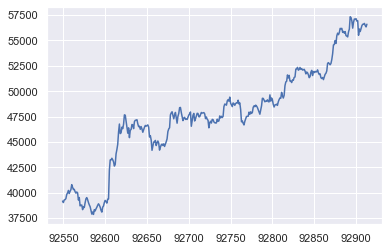

In [ ]:
close_train.plot()

<AxesSubplot:>

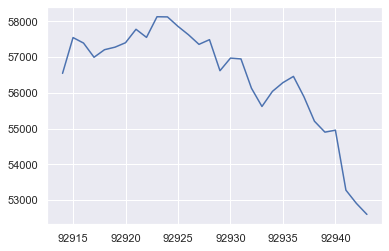

In [ ]:
close_val.plot()

<AxesSubplot:>

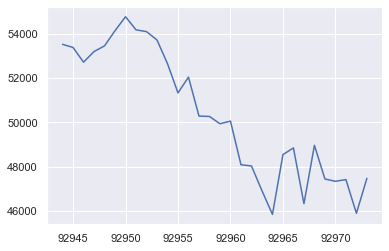

In [ ]:
close_test.plot()

In [ ]:
close_train.index[-1], close_test.index[0]

(92943, 92944)

In [ ]:
close_train.shape

(365,)

In [ ]:
def train_val_test_split(sequences, targets):
    

In [ ]:
# Prep for training
training_set = close_train.values.reshape(-1, 1)
training_set = min_max.fit_transform(training_set)
training_set = training_set.reshape((-1, 1, 1))

validation_set = close_val.values.reshape(-1, 1)
validation_set = min_max.transform(validation_set)
validation_set = validation_set.reshape((-1, 1, 1))

# Prep for testing
testing_set = close_test.values.reshape((-1, 1))
testing_set = min_max.transform(testing_set)
testing_set = testing_set.reshape((-1, 1, 1))

# We are training to predict the next day's close
# so cut off final val for X_train and start at index 1 for
# y_train
X_train = training_set[:-1]
y_train = training_set[1:]

X_val = validation_set[:-1]
y_val = validation_set[1:]

X_test = testing_set[:-1]
y_test = testing_set[1:]

In [ ]:
regressor = Sequential([
    LSTM(4),
    Dense(1)
])
regressor.compile(optimizer='adam', 
                  loss='mse',
                  metrics=[RootMeanSquaredError()])

history = regressor.fit(X_train, 
                        y_train, 
                        batch_size=5, 
                        epochs=100,
                        shuffle=False,
                        validation_data=(X_val, y_val))

Train on 364 samples, validate on 29 samples
Epoch 1/100
364/364 [==============================] - 5s 13ms/sample - loss: 0.1535 - root_mean_squared_error: 0.3917 - val_loss: 0.3875 - val_root_mean_squared_error: 0.6225
Epoch 2/100
364/364 [==============================] - 0s 930us/sample - loss: 0.0685 - root_mean_squared_error: 0.2618 - val_loss: 0.2199 - val_root_mean_squared_error: 0.4690
Epoch 3/100
364/364 [==============================] - 0s 947us/sample - loss: 0.0336 - root_mean_squared_error: 0.1832 - val_loss: 0.1264 - val_root_mean_squared_error: 0.3556
Epoch 4/100
364/364 [==============================] - 0s 998us/sample - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0827 - val_root_mean_squared_error: 0.2877
Epoch 5/100
364/364 [==============================] - 0s 1ms/sample - loss: 0.0226 - root_mean_squared_error: 0.1504 - val_loss: 0.0632 - val_root_mean_squared_error: 0.2513
Epoch 6/100
364/364 [==============================] - 0s 977us/sample - 

364/364 [==============================] - 0s 927us/sample - loss: 4.6616e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1631e-04 - val_root_mean_squared_error: 0.0286
Epoch 91/100
364/364 [==============================] - 0s 883us/sample - loss: 4.6636e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1715e-04 - val_root_mean_squared_error: 0.0286
Epoch 92/100
364/364 [==============================] - 0s 889us/sample - loss: 4.6656e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1797e-04 - val_root_mean_squared_error: 0.0286
Epoch 93/100
364/364 [==============================] - 0s 872us/sample - loss: 4.6676e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1876e-04 - val_root_mean_squared_error: 0.0286
Epoch 94/100
364/364 [==============================] - 0s 831us/sample - loss: 4.6694e-04 - root_mean_squared_error: 0.0216 - val_loss: 8.1953e-04 - val_root_mean_squared_error: 0.0286
Epoch 95/100
364/364 [==============================] - 0s 846us/sample - loss: 4.6

In [ ]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

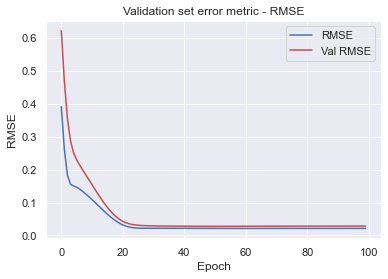

In [ ]:
rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']

fig, ax = plt.subplots()
plt.plot(rmse, 'b', label='RMSE')
plt.plot(val_rmse, 'r', label='Val RMSE')
ax.set(xlabel='Epoch', ylabel='RMSE',
      title='Validation set error metric - RMSE')
# plt.yticks([0, .1, .2, .3, .4])
plt.legend()
plt.show()

In [ ]:
# Smallest rmse
min(val_rmse), np.argmin(val_rmse)

(0.02795342, 50)

In [ ]:
val_rmse[-1]

0.028698

~3% of max change in dataset. We think this is not very good. A 3% price change is significant. Hard to interpret. 

In [ ]:
# Smallest loss
min(val_loss), np.argmin(val_loss)

(0.0007813936611236041, 50)

In [ ]:
history.history['val_root_mean_squared_error'][-1]

0.028698

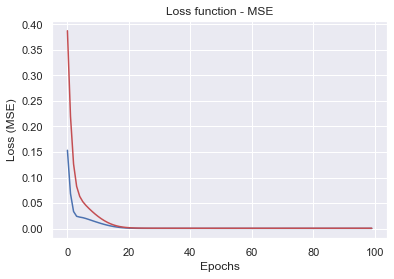

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots()
plt.plot(loss, 'b', label='Loss (MSE)')
plt.plot(val_loss, 'r', label='Val Loss (MSE)')
ax.set(xlabel='Epochs', ylabel='Loss (MSE)',
      title='Loss function - MSE')
plt.show()

In [ ]:
predicted_price = regressor.predict(X_test)
predicted_price = min_max.inverse_transform(predicted_price)

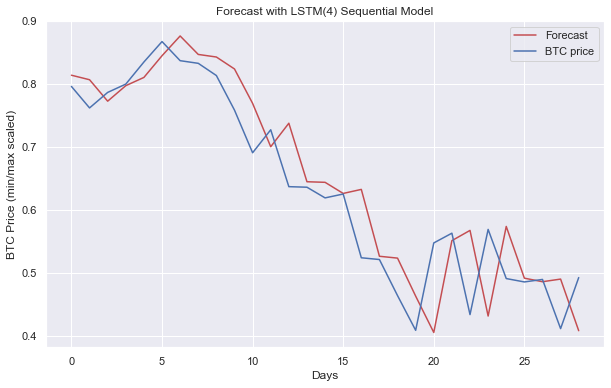

In [ ]:
# Need to inverse transform to get correct y-axis values
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(regressor.predict(X_test), 'r', label='Forecast')
plt.plot(np.ravel(y_test), 'b', label='BTC price')
plt.legend()
ax.set(xlabel='Days', ylabel='BTC Price (min/max scaled)',
      title='Forecast with LSTM(4) Sequential Model')
plt.show()

This is expected (from a model doing a very bad job). Trained on bull data and validated on bear data. 

In [ ]:
# Loss for this model
rmse_class = RootMeanSquaredError()
rmse_class(y_test, regressor.predict(X_test)).numpy()

0.06531364

In [ ]:
# WHY IS THIS DIFFERENT TO THE VALIDATION_RMSE????
rmse_class(y_val, regressor.predict(X_val)).numpy()

0.05044525

In [ ]:
rmse_class(y_train, regressor.predict(X_train)).numpy()

0.027286403

# LSTMs

## Info

Couple of helpful ML Mastery articles:
- [How to Reshape Input Data for LSTMs - Keras](https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/)
- [How to Prepare Univariate Time Series Data for LSTMs](https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/)

Univariate is when we just have a time column and a column that we are trying to predict.

There are many ways to split up our time series data and exploring these would definititely be fruitful and beneficial for the problem e.g. maybe we need overlapping sequences, perhaps non-overlapping is better but the model needs to maintain state across the sub-sequences and so on.

Input to LSTMs in Keras must be `[samples, timesteps, features]`. Note that `timesteps` is a vital tuning parameter, so just picking 1 week's worth of data is not going to cut it. Jason says that 200-400 timesteps is usually optimal though.

[Choosing the timestamp split](https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/) will be an important hyperparameter. Totally possible to have disjoint sequences. 

What does it mean to keep the internal state preserved or not? What happens if we do/n't do this?

## Attempt Two

In [ ]:
def make_seqs_and_targets(data, seq_length):
    """
    Return a tuple of (seq, target) pairs.
    The target is the next element in the series.
    
    We assume this is a univariate timeseries problem and thus data should only
    contain one feature.
    
    seqs output shape: [num_samples, seq_length, 1] (as required by Keras)
    num_samples is calculated below and varies based on seq_length and len(series)
    """
    if len(data.shape) > 2 and data.shape[1] > 1:
        raise TypeError('Data must be univariate')
    if not isinstance(data, np.ndarray):
        data = data.values

    seqs = []
    targets = []
    i = 0
    while i + seq_length < len(data):
        seq = data[i : i + seq_length]
        target = data[i + seq_length]
        seqs.append(seq)
        targets.append(target)
        i += 1

    seqs = np.array(seqs)
    targets = np.array(targets)
    
    seqs = seqs.reshape(-1, seq_length, 1) # Univariate timeseries data
    return seqs, targets

In [ ]:
# Found by inspection
price_nonans = price.iloc[76307:]

In [ ]:
len(price_nonans)

16667

In [ ]:
seqs, targets = make_seqs_and_targets(price_nonans.c, 168)

In [ ]:
targets.shape

(16499,)

In [ ]:
num_samples = seqs.shape[0]
num_train_samples = int(num_samples * 0.6)
num_val_samples = int(num_samples * 0.2) + 1
num_test_samples = int(num_samples * 0.2) + 1

In [ ]:
num_train_samples + num_val_samples + num_test_samples == num_samples

True

In [ ]:
X_train, y_train = seqs[:num_train_samples], targets[:num_train_samples]
X_val, y_val = seqs[num_train_samples:num_train_samples + num_val_samples], \
               targets[num_train_samples:num_train_samples + num_val_samples]
X_test, y_test = seqs[-num_test_samples:], targets[-num_test_samples:]

In [ ]:
len(X_val)

3300

In [ ]:
len(X_train) / 400

24.7475

# RUN THIS AGAIN BUT UPLOAD IT TO WANDB!!!

In [ ]:
# Initalize wandb with project name
run = wandb.init(project='bitcoin_price_predictor',
                 config={ # and include hyperparameters and metadata
                    'batch_size': 400,
                    'epochs': 200,
                    'loss_function': 'mse',
                    'shuffle': False,
                    'optimizer': 'adam',
                    'metrics': None
                 })
config = wandb.config # we use this to configure our experiment

# Init model like usual
model = Sequential([
    LSTM(32, input_shape=(168, 1)),
    Dense(1)
])
model.summary()

# Compile model like usual (but use config. for all params)
# is this really necessary? What happens if I don't use config.???
model.compile(optimizer=config.optimizer,
             loss=config.loss_function,
             metrics=[config.metrics])

epoch,49
loss,74897416.0
val_loss,106733296.0
_runtime,58
_timestamp,1615213177
_step,49
best_val_loss,106733296.0
best_epoch,49


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 32)                4352      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Fit as normal - use config. for everything and add WandbCallback
history = model.fit(X_train, 
                    y_train, 
                    batch_size=config.batch_size, 
                    epochs=config.epochs,
                    shuffle=config.shuffle,
                    validation_data=(X_val, y_val),
                    callbacks=[WandbCallback()])

Epoch 1/200
25/25 [==============================] - 3s 37ms/step - loss: 71483143.7692 - val_loss: 106991992.0000
Epoch 2/200
25/25 [==============================] - 0s 15ms/step - loss: 71480212.3846 - val_loss: 106988296.0000
Epoch 3/200
25/25 [==============================] - 0s 15ms/step - loss: 71477288.2308 - val_loss: 106984608.0000
Epoch 4/200
25/25 [==============================] - 0s 15ms/step - loss: 71474363.2308 - val_loss: 106980936.0000
Epoch 5/200
25/25 [==============================] - 0s 15ms/step - loss: 71471430.8462 - val_loss: 106977256.0000
Epoch 6/200
25/25 [==============================] - 0s 15ms/step - loss: 71468501.0000 - val_loss: 106973568.0000
Epoch 7/200
25/25 [==============================] - 0s 15ms/step - loss: 71465570.5385 - val_loss: 106969904.0000
Epoch 8/200
25/25 [==============================] - 0s 15ms/step - loss: 71462629.8462 - val_loss: 106966208.0000
Epoch 9/200
25/25 [==============================] - 0s 15ms/step - loss: 714597

Doesn't look like having unnormalized data is very helpful.

## LSTM with Normalized Data

We need to split the data first (train, val, test) and then scale before we turn it into the sequences we want to feed into the LSTM.

When we call `int()` it always rounds down. Perhaps `math.floor()` would be better or even fucking floor division!

We only need to define two of the three sizes. Since they sum to one. So we just need the sizes for train and val and then test will be 1-that. 

Wait... I need to put in the targets too but the targets exist from the features. 

So I need to scale all the data using the train/val/test sizes I've specified. 

Jason says I need to [reframe my time-series problem as a supervised ML problem](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/). 

Think it makes sense to first transform the problem into a supervised ML task. 

Can defo make use of the `series_to_supervised` function in the above article to elegantly reframe the dataset before moving on. This may make it possible to just `fit_transform()` the whole dataset and then

In [ ]:
def train_val_test_split(data, train_size=0.6, val_size=0.2):
    """
    data should be a dataframe, series or numpy object in its original (probably
    tabular) form. It should _not_ be in a form ready to be fed into an LSTM,
    we will do that transformation after this. 

    We need to split the data first if we are to transform it before feeding it
    into our LSTM.
    """
    assert train_size + val_size < 1

    num_samples = len(data)
    # int() rounds all numbers down
    num_train_samples = int(num_samples * train_size)
    num_val_samples = int(num_samples * val_size)

    # Slice dataset into train-val-test
    X_train = data[:num_train_samples]
    X_val = data[num_train_samples:num_train_samples + num_val_samples]
    X_test = data[num_train_samples + num_val_samples:]

    # Turn into 2D arraus
    X_train = X_train.values.reshape(-1, 1)
    X_val = X_val.values.reshape(-1, 1)
    X_test = X_test.values.reshape(-1, 1)

    return X_train, X_val, X_test

In [ ]:
X_train, X_val, X_test = train_val_test_split(price_nonans.c)

In [ ]:
len(X_train) + len(X_val) + len(X_test) == len(price_nonans.c)

True

In [ ]:
X_train.shape

(10000, 1)

In [ ]:
min_max = MinMaxScaler()

X_train_scaled = min_max.fit_transform(X_train)
X_val_scaled = min_max.transform(X_val)
X_test_scaled = min_max.transform(X_test)

In [ ]:
type(X_train_scaled)
isinstance(X_train_scaled, np.ndarray)

True

In [ ]:
X_train, y_train = make_seqs_and_targets(X_train_scaled, 168)
X_val, y_val = make_seqs_and_targets(X_val_scaled, 168)
X_test, y_test = make_seqs_and_targets(X_test_scaled, 168)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(9832, 168, 1) (9832, 1)
(3165, 168, 1) (3165, 1)
(3166, 168, 1) (3166, 1)


# NaN Investigation

Tldr: drop them, only 55 NaNs in total after 2011 across 7 days.

In [ ]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
# price = pd.read_csv('price.csv')
close = price.loc[:, 'c']

In [ ]:
price[close.isna()].to_csv('Nans.csv')

In [ ]:
price.head()

,c,h,l,o
timestamp,,,,
2010-07-17 23:00:00+00:00,0.04951,0.04951,0.04951,0.04951
2010-07-18 00:00:00+00:00,NaN,NaN,NaN,NaN
2010-07-18 01:00:00+00:00,NaN,NaN,NaN,NaN
2010-07-18 02:00:00+00:00,NaN,NaN,NaN,NaN
2010-07-18 03:00:00+00:00,0.05941,0.05941,0.05941,0.05941


In [ ]:
price.c.isna()

DatetimeIndex(['2010-07-17 23:00:00+00:00', '2010-07-18 00:00:00+00:00',
               '2010-07-18 01:00:00+00:00', '2010-07-18 02:00:00+00:00',
               '2010-07-18 03:00:00+00:00', '2010-07-18 04:00:00+00:00',
               '2010-07-18 05:00:00+00:00', '2010-07-18 06:00:00+00:00',
               '2010-07-18 07:00:00+00:00', '2010-07-18 08:00:00+00:00',
               ...
               '2021-02-23 11:00:00+00:00', '2021-02-23 12:00:00+00:00',
               '2021-02-23 13:00:00+00:00', '2021-02-23 14:00:00+00:00',
               '2021-02-23 15:00:00+00:00', '2021-02-23 16:00:00+00:00',
               '2021-02-23 17:00:00+00:00', '2021-02-23 18:00:00+00:00',
               '2021-02-23 19:00:00+00:00', '2021-02-23 20:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', length=92974, freq=None)

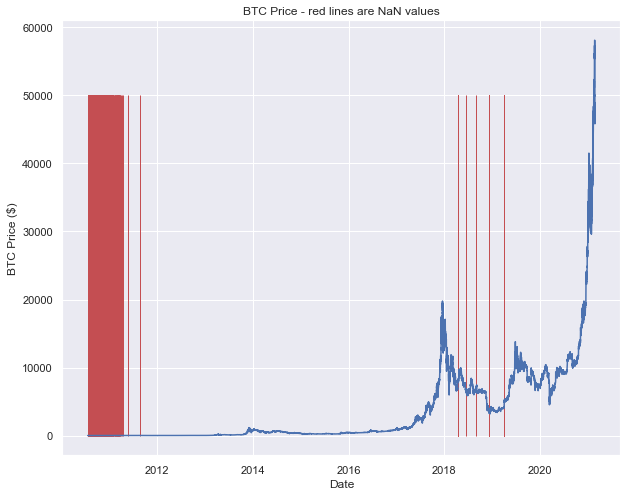

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
c_nans = price.c[price.c.isna()]
c_no_nans = price.c[price.c.notna()]
# plt.scatter(c_no_nans.index, c_no_nans.values, s=1)
plt.plot(c_no_nans)
plt.vlines(c_nans.index, ymin=0, ymax=50000, colors='r', linewidths=1)
ax.set(xlabel='Date', ylabel='BTC Price ($)', 
       title='BTC Price - red lines are NaN values')
plt.show()

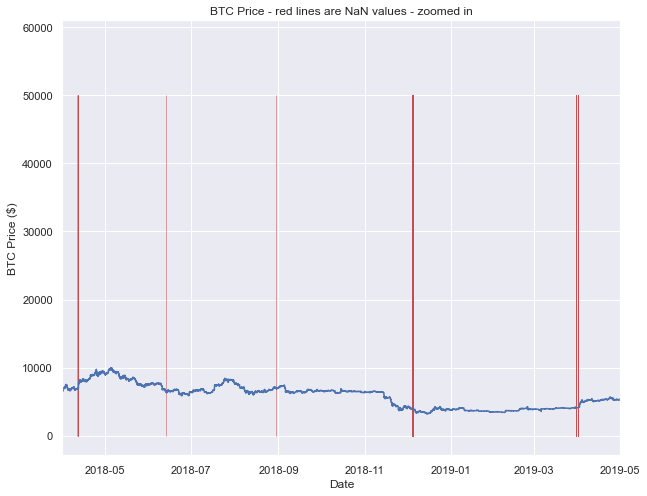

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
c_nans = price.c[price.c.isna()]
c_no_nans = price.c[price.c.notna()]
# plt.scatter(c_no_nans.index, c_no_nans.values, s=1)
plt.plot(c_no_nans)
plt.vlines(c_nans.index, ymin=0, ymax=50000, colors='r', linewidths=0.5)
plt.xlim((np.datetime64('2018-04'), np.datetime64('2019-05')))
ax.set(xlabel='Date', ylabel='BTC Price ($)', 
       title='BTC Price - red lines are NaN values - zoomed in')
plt.show()

In [ ]:
# Only 55 hours missing after 2011 (all in 2018 and 2019)
len(c_nans.loc['2012':])

55

In [ ]:
# Only across 7 days
len(np.unique(c_nans.loc['2012':].index.date))

7

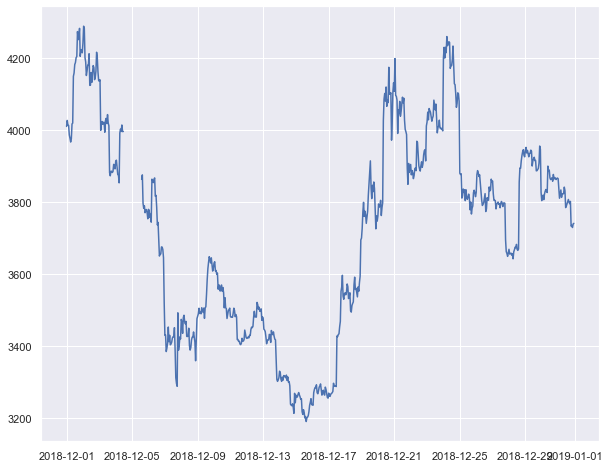

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(price.c.loc['2018-12'])

In [ ]:
c_nans_removed = price.c.dropna()

# ML Mastery Follow Along

Walkthrough of [this](https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/) article

In [ ]:
c_nans_removed.shape

(92192,)

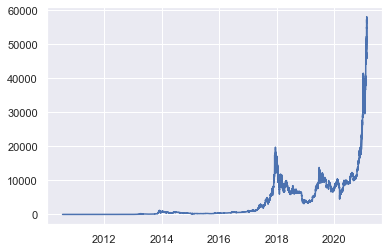

In [ ]:
plt.plot(c_nans_removed)
plt.show()

## Creating a baseline model

We won't do this here for brevity.

### Train-Test Split

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] \
            for i in range(interval, len(data))]

### Series as Supervised Learning

Need to frame as supervised ML problem

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [ ]:
series_to_supervised(price.c, n_in=168).shape

(85187, 169)

### Walk-Forward Validation

Forcast for each observation in the test dataset one at a time. After each forecast is made for a time step in the test dataset, the true observation for the forecast is added to the test dataset and made available to the model. 

You can refit simpler models but more complex ones e.g. NNs are not refit given the computational cost. Something to toy with here. But we can still use the new input to make a prediction which is something at least. 

Generic func to fit the model once on the train dataset and for a specific model config. Takes train, model config and returns the fit model ready to make predictions.

In [ ]:
# fit a model
def model_fit(train, config):
    return None

As each time step of the dataset is enumerated, we make a prediction with the fit model. 

The func `model_predict()` takes the fit model, the history, and the model config and makes a single one-step prediction.

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):
    return 0.0

We add this pred to the list of preds and true observation is added to the list of observations. Both lists grow on each step in the walk-forward validation.

Then we compare all the preds to the true values in the test set and calc and error measure.

In [ ]:
# root mean squared error, or rmse
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

Complete walk-forward validation function.

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, config):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test dataset
    for i in range(len(test)):
        # use fitted model to make forecast
        yhat = model_predict(model, history, config)
        # store forecaxst in the list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

### Repeat Evaluation

Given the stochastic nature of NNs, we want to repeat our evaluations multiple times.

In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate model n times
    scores = [walk_forward_validation(data, n_test, config) \
              for _ in range(n_repeats)]
    return scores

### Summarize Performance

In [ ]:
# Summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, scores_std = np.mean(scores), np.std(scores)
    print(f'{name}: {scores_m:.3f} RMSE (+/- {scores_std:.3f})')
    sns.boxplot(x=scores)
    plt.show()

## Baseline Model - Persistence (average of last week)

In [ ]:
# Nothing to fit
def model_fit(train, config):
    return None

def model_predict(model, history, config):
    values = []
    for offset in config:
        values.append(history[-offset])
    return np.mean(values)

 > 946.621
 > 946.621
 > 946.621
 > 946.621
 > 946.621
persistence: 946.621 RMSE (+/- 0.000)


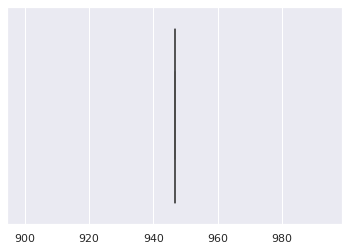

In [ ]:
price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
close = price.loc[:, 'c'].dropna()
data = close.values
# data split
n_test = int(len(data) * 0.33)
# define config
config = np.arange(1, 169)
# grid search
scores = repeat_evaluate(data, config, n_test, 5)
summarize_scores('persistence', scores)

## MLP

Currently, we are using an autoregressive approach. In other words, we are assuming that the next time step was taken as a function of some number of past (or lag) observations.

This is a common approach for classical statistical time series forecasting.

Note that it makes a lot of sense to evaluate an MLP first as well. We want to know that our LSTM is definitely better.

The function `series_to_supervised()` does exactly what we want. It frames the problem perfectly for an MLP.

The model has input layer with some number of prior observations, we specify with `input_dim`. 

Note that the number of lag observations (`n_input`), the number of nodes in our (for the moment) single layer (`n_nodes`), the number of training epochs (`n_epochs`) and batch size (`n_batch`) are all hyperparameters that will need tuning. 

Remember that, for walk-forward validation, we are only making one prediction at a time and so will not use the bulk prediction features of Keras. 

Thus the input to `model.predict()` must be of shape `(1, n_input)` as `n_input` is the number of lag observations we will include.

epoch,62
loss,104608.90625
val_loss,279382.5
_runtime,9
_timestamp,1616071035
_step,62
best_val_loss,150733.0625
best_epoch,48


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▁█▁▁▁▁▁▁▁▁▁▁▁▂▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▁▁
val_loss,▁█▂▁▁▁▁▁▁▁▁▁▁▂▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


Repeat #0



 > 964.268


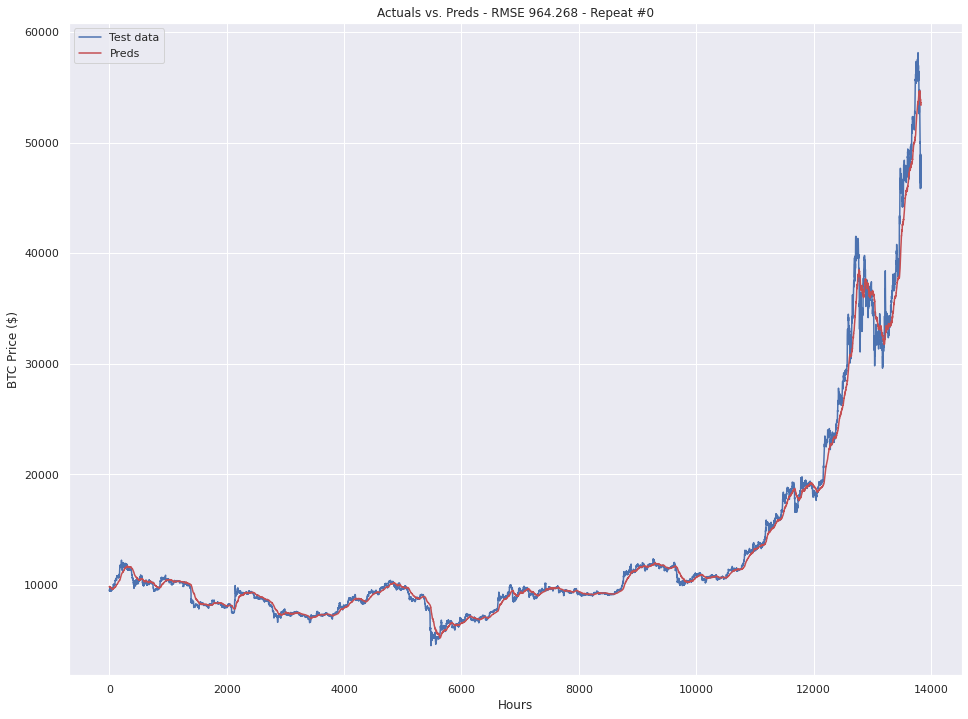

Repeat #1



 > 999.530


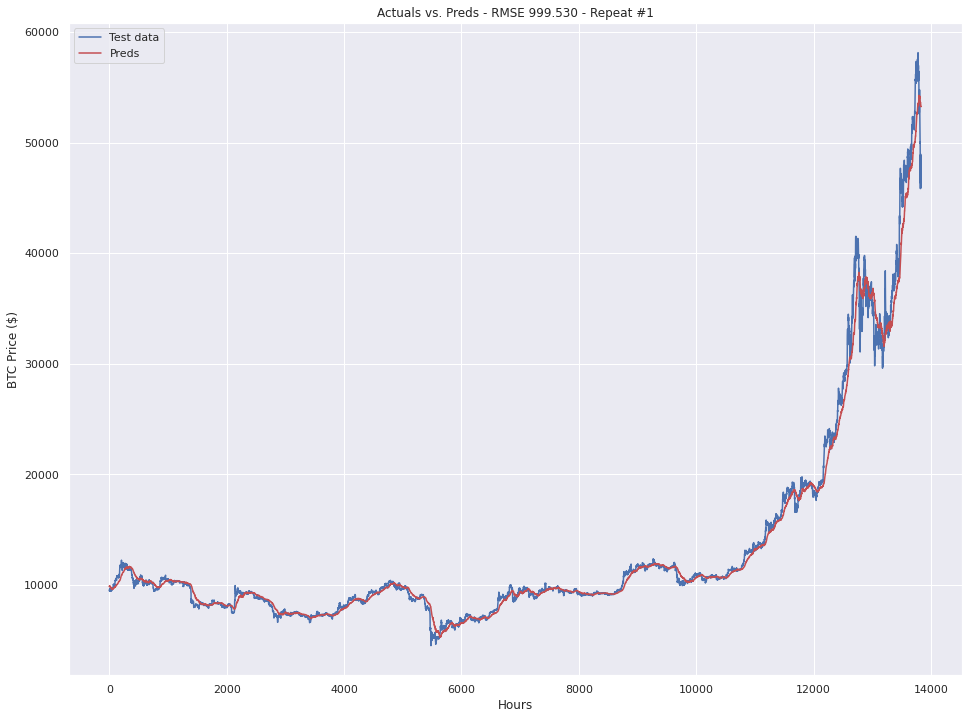

Repeat #2



 > 750.975


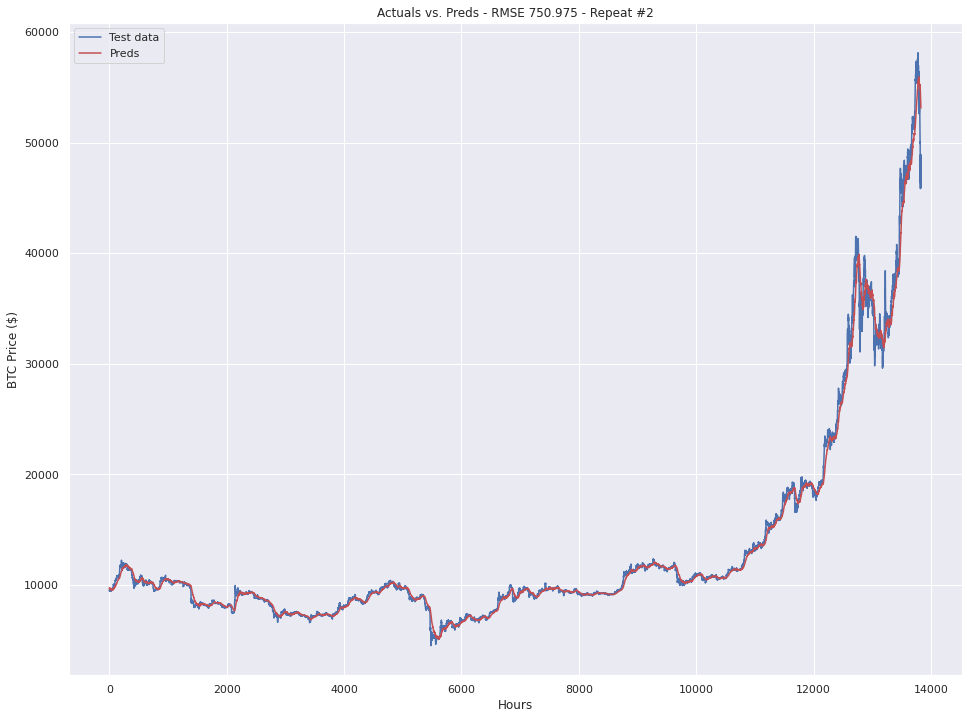

Repeat #3



 > 2169.770


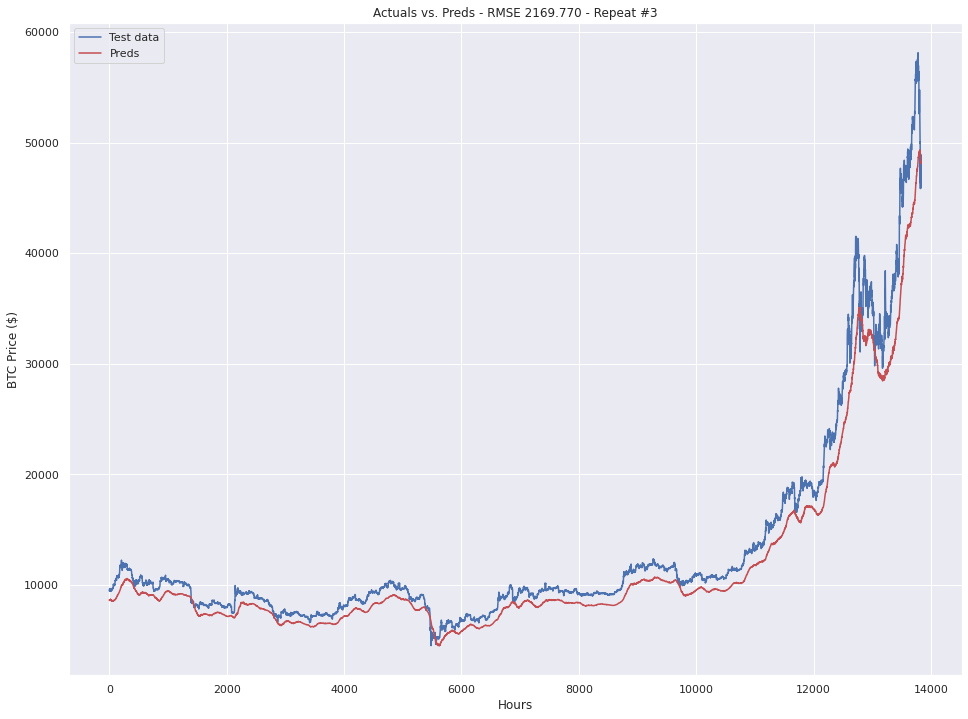

Repeat #4



 > 959.432


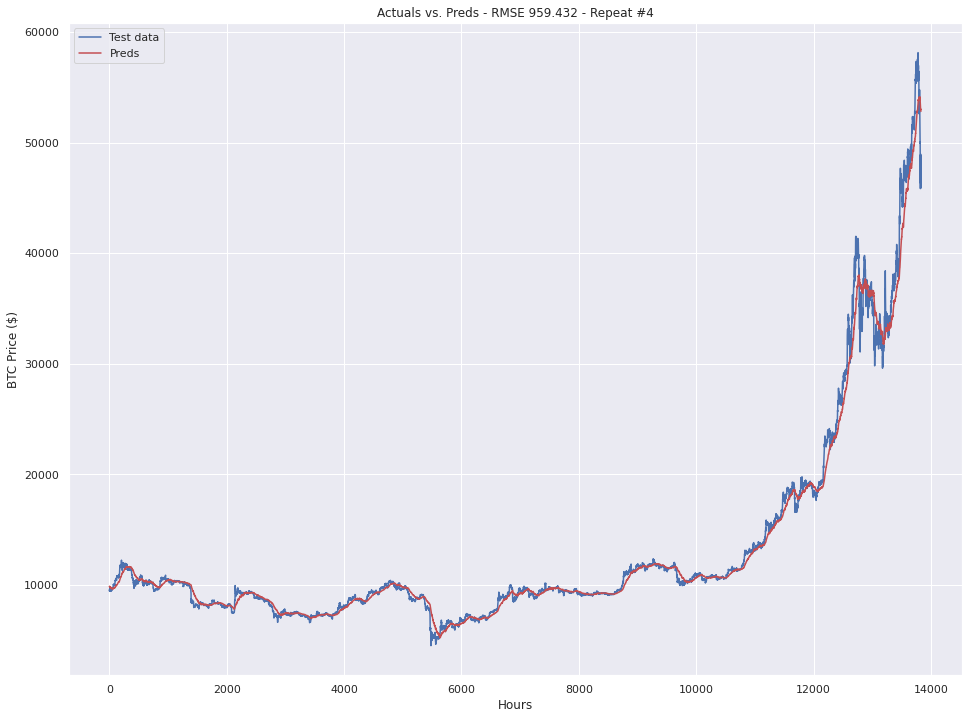

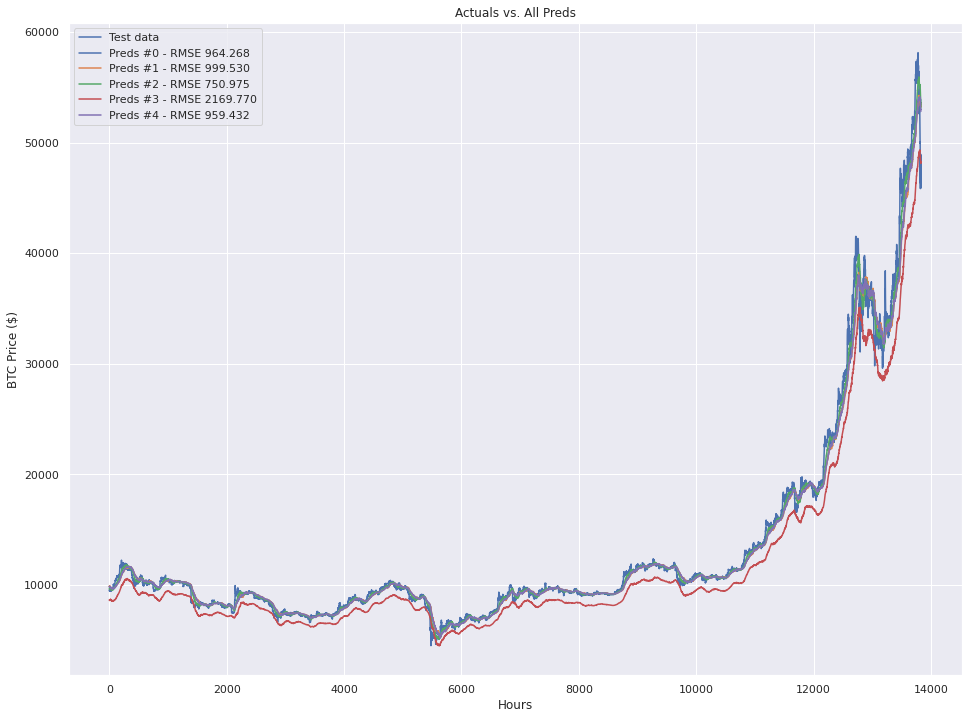

mlp: 1168.795 RMSE (+/- 508.102)


NameError: ignored

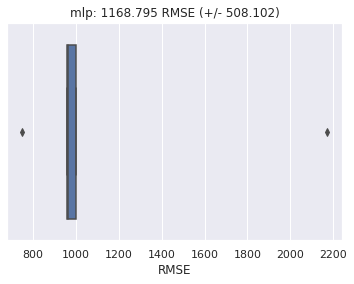

In [ ]:
# Initalize wandb with project name
run = wandb.init(project='bitcoin_price_predictor',
                 config={
                     'test_size': 0.15,
                     'n_input': 168, # num lag observations
                     'n_nodes': 300, # num nodes per lauyer
                     'n_epochs': 200, # num training epochs
                     'n_batch': 168 * 20, # batch size
                     'n_repeats': 5, # num repeats of WF validation
                     'activation': 'relu',
                     'loss': 'mse',
                     'optimizer': 'adam',
                     'val_split': 0.15,
                     'verbose': 0, # control verbosity of Keras fit
                     'dropna': True # whether to drop missing values from data
                         })
config = wandb.config # we use this to configure our experiment

data = load_close_data(DOWNLOAD_DIR, dropna=config.dropna)
n_test = get_n_test_samples(data, config.test_size)
scores = repeat_evaluate(data, 
                         config, 
                         n_test, 
                         n_repeats=config.n_repeats)
summarize_scores('mlp', scores)

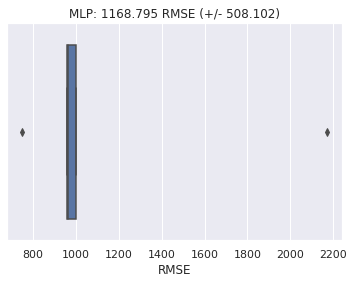

In [ ]:
a = np.array([964.268, 999.530, 750.975, 2169.770, 959.432])
fig, ax = plt.subplots()
boxplot = sns.boxplot(x=a, ax=ax)
mean, std = np.mean(a), np.std(a)
ax_title = f'MLP: {mean:.3f} RMSE (+/- {std:.3f})'
ax.set(xlabel='RMSE',
       title=ax_title)
log_title = 'RMSE Walk-Forward Validation Scores Distribution'
wandb.log({log_title: wandb.Image(fig)})
plt.show()

In [ ]:
run.finish()

epoch,199
loss,52913.73438
val_loss,107257.40625
_runtime,3604
_timestamp,1616074657
_step,1007
best_val_loss,54751.44922
best_epoch,84


epoch,▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█▁▂▃▄▅▆▇█
loss,▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁█▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅█
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Great! So this has an average loss of $452 (without any scaling or anything). Amazing.

## LSTM

Plenty of variation for us to try here.

- LSTM 
- CNN-LSTM - CNN learns input features, LSTM interprets them
- ConvLSTM - LSTM units read input data using the convolutional process of a CNN.

LSTMs read each time step one at a time _but_ it remembers the internal state as it reads across time steps.

LSTMs usually preform better if the data is stationary. So, we perform difference opeations to remove trends and seasonal structures. Obvs we should check if it actually makes a difference. Need to test this.

For [Jason's example](https://machinelearningmastery.com/how-to-develop-deep-learning-models-for-univariate-time-series-forecasting/) he subtracts the value from one year ago for each observation.

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


def series_to_supervised(data, n_in=1, n_out=1):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error, or rmse
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))


# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] \
            for i in range(interval, len(data))]


def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((-1, n_input, 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='tanh', stateful=False,
                   input_shape=(n_input, 1)))
                #    batch_input_shape=(n_batch, n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=optimizer)
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, 
              batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = np.array(history[-n_input:]).reshape(1, n_input, 1)
    # forecast, one at a time
    yhat = model.predict(x_input, verbose=0)
    return yhat[0] + correction

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, config):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, config)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test dataset
    for i in trange(len(test)):
        # use fitted model to make forecast
        yhat = model_predict(model, history, config)
        # store forecaxst in the list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    scores = []
    for i in range(n_repeats):
        print(f'Repeat #{i}')
        score = walk_forward_validation(data, n_test, config)
        scores.append(score)
    return scores

# Summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, scores_std = np.mean(scores), np.std(scores)
    print(f'{name}: {scores_m:.3f} RMSE (+/- {scores_std:.3f})')
    sns.boxplot(x=scores)
    plt.show()

price = pd.read_csv(DOWNLOAD_DIR / 'price.csv', parse_dates=[0])
price = price.set_index('timestamp')
close = price.loc[:, 'c'].dropna()
data = close.values
# data split ~8k observations
n_test = int(len(data) * 0.10)
# num_lag_observations, num_nodes_in_layer, num_training_epochs, batch_size, stationary_interval
config = [168, 200, 300, 168 * 50, 0]
# grid search
scores = repeat_evaluate(data, config, n_test, n_repeats=30)
summarize_scores('lstm', scores)

Repeat #0



 > 10965.856
Repeat #1


### series_to_supervised with scaling

In [ ]:
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


def series_to_supervised(data, n_in=1, n_out=1, n_test=None):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# Learning Curves for DL Time Series Models

Let's plot some learning curves

In [ ]:
from helpers import _train_test_split, _model_fit

In [ ]:
# Initalize wandb with project name
run = wandb.init(project='bitcoin_price_predictor',
                 config={
                     'test_size': 0.15,
                     'n_input': 168, # num lag observations
                     'n_nodes': 300, # num nodes per lauyer
                     'n_epochs': 500, # num training epochs
                     'n_batch': 168 * 20, # batch size
                     'n_repeats': 5, # num repeats of WF validation
                     'activation': 'relu',
                     'loss': 'mse',
                     'optimizer': 'adam',
                     'val_split': 0.15,
                     'verbose': 1, # control verbosity of Keras fit
                     'dropna': True # whether to drop missing values from data
                         })
config = wandb.config # we use this to configure our experiment

data = load_close_data(DOWNLOAD_DIR, dropna=config.dropna)
n_test = get_n_test_samples(data, config.test_size)
train, test = _train_test_split(data, n_test)
model, history = _model_fit(train, config)

epoch,199
loss,45267.35156
val_loss,92765.11719
_runtime,860
_timestamp,1616076891
_step,200
best_val_loss,69673.0
best_epoch,171


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Epoch 1/500
20/20 [==============================] - 0s 12ms/step - loss: 385252.1571 - val_loss: 157193.3125
Epoch 2/500
20/20 [==============================] - 0s 5ms/step - loss: 14909811.8176 - val_loss: 435481664.0000
Epoch 3/500
20/20 [==============================] - 0s 6ms/step - loss: 9141417.9154 - val_loss: 397781632.0000
Epoch 4/500
20/20 [==============================] - 0s 5ms/step - loss: 79983.2630 - val_loss: 441104.0312
Epoch 5/500
20/20 [==============================] - 0s 5ms/step - loss: 175909.5023 - val_loss: 7109058.0000
Epoch 6/500
20/20 [==============================] - 0s 5ms/step - loss: 15707.1923 - val_loss: 507430.8125
Epoch 7/500
20/20 [==============================] - 0s 5ms/step - loss: 8332.2349 - val_loss: 155667.1406
Epoch 8/500
20/20 [==============================] - 0s 6ms/step - loss: 7672.3095 - val_loss: 156120.9844
Epoch 9/500
20/20 [==============================] - 0s 5ms/step - loss: 7523.6813 - val_loss: 140558.8594
Epoch 10/500
20/

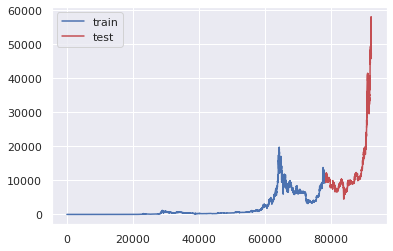

In [ ]:
plt.plot(train, 'b', label='train')
plt.plot([None for i in train] + [x for x in test], 'r', label='test')
plt.legend()
plt.show()

In [ ]:
def plot_losses(history):
    fig, ax = plt.subplots()
    num_epochs_trained = len(history.history['loss'])
    epochs = np.arange(1, num_epochs_trained + 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'b:', label='Training')
    plt.plot(epochs, val_loss, 'b', label='Validation')
    ax.set(title='Loss - Training and Validation',
           xlabel='Epoch',
           ylabel='Loss', 
           ylim=(85000, 150000))
    ax.legend()
    wandb.log({'Loss - Training and Validation': wandb.Image(fig)})
    plt.show()

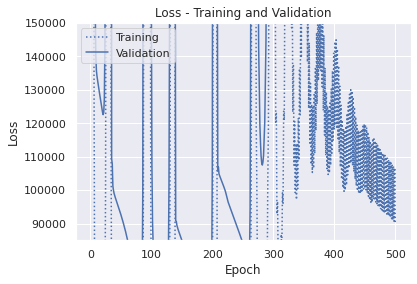

In [ ]:
plot_losses(history)

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
df = pd.DataFrame(data={'loss': history.history['loss'],
                        'val_loss': history.history['val_loss']})
df['difference'] = df.val_loss - df.loss 

In [ ]:
df.difference.tail()

495    175393.437500
496    234738.984375
497    174631.070312
498    233587.578125
499    173879.117188
Name: difference, dtype: float64

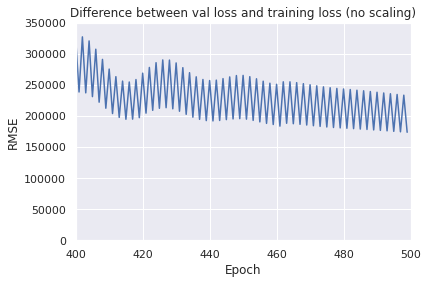

In [ ]:
fig, ax = plt.subplots()
ax.plot(df.difference)
ax.set(xlim=(400, 500),
       ylim=(0, 350000),
       xlabel='Epoch',
       ylabel='RMSE',
       title='Difference between val loss and training loss (no scaling)')
wandb.log({'Difference between val loss and training loss': wandb.Image(fig)})
plt.show()

In [ ]:
run.finish()

epoch,499
loss,90341.07031
val_loss,264220.1875
_runtime,614
_timestamp,1616077530
_step,503
best_val_loss,61915.45312
best_epoch,195


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▁▆▁▁▁▁▇▁▁▁▁▁▁▁▁█▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▅▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂█
_timestamp,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Clearly these numbers are SO FUCKING HIGH. Let's see what happens when I apply scaling. Will the same problems exist or not? If they do, I will probably have to write my own fit and validation loop #exciting.

# Buiding Scaled Models

In [ ]:
from helpers import _series_to_supervised, _plot_actual_vs_pred, plot_metric, \
                    _plot_preds_grid
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras.optimizers import Adam


def get_n_val_and_n_test(data, val_size, test_size):
    n_val = int(len(data) * val_size)
    n_test = int(len(data) * test_size)  
    return n_val, n_test


def train_val_test_split(data, n_val, n_test):
    test = data[-n_test:]
    val = data[-n_test - n_val : -n_test]
    train = data[:-n_test - n_val]
    return train, val, test


def plot_train_val_test(train, val, test):
    fig, ax = plt.subplots()
    ax.plot(train, 'b', label='Train')
    ax.plot([None for x in train] + [x for x in val], 'r', label='Val')
    ax.plot([None for x in train] + [None for x in val] + [x for x in test],
            'g', label='Test')
    ax.legend()
    plt.show()


# I can easily add more functionality to this by writing
# other functions like min_max_scale_train_val_test()
# and add them under each 'if scaler == 'min_max': 
def scale_train_val_test(train, val, test=None, scaler='log'):
    if scaler.lower() != 'log':
        raise TypeError("Only 'log' scaling supported at this time." )
    # Log scale
    train = np.log(train)
    val = np.log(val)
    if test:
        test = np.log(test)
        return train, val, test
    else:
        return train, val


def inverse_scale(data, scaler='log'):
    if scaler.lower() != 'log':
        raise TypeError("Only 'log' scaling supported at this time." )
    # Inverse log scale
    inverse_scaled_data = [np.exp(d) for d in data]
    return inverse_scaled_data

# Create train and val sets to input into Keras model
# we do not need test sets at this stage, just care about 
# validation, not testing
def transform_to_keras_input(train, val, n_in):
    # Transform to keras input
    train_data = _series_to_supervised(train, n_in=n_in)
    val_data = _series_to_supervised(val, n_in=n_in)
    # Create X and y variables
    X_train, y_train = train_data[:, :-1], train_data[:, -1]
    X_val, y_val = val_data[:, :-1], val_data[:, -1]
    return X_train, X_val, y_train, y_val


def build_model(config):
    model = Sequential([
        Dense(config.n_nodes, activation=config.activation,
              input_dim=config.n_input),
        Dense(config.n_nodes, activation=config.activation),
        Dense(config.n_nodes, activation=config.activation),
        Dense(1)
    ])
    learning_rate_schedule = InverseTimeDecay(config.initial_lr,
                                              config.decay_steps,
                                              config.decay_rate)
    optimizer = Adam(learning_rate_schedule)
    model.compile(loss=config.loss, 
                  optimizer=optimizer,
                  metrics=[RootMeanSquaredError()])
    return model


def fit_model(model, config, X_train, X_val, y_train, y_val):
    history = model.fit(
                X_train, 
                y_train, 
                epochs=config.n_epochs,
                batch_size=config.n_batch, 
                verbose=config.verbose,
                shuffle=False, 
                validation_data=(X_val, y_val),
                callbacks=[WandbCallback()])
    return history


def get_training_data():
    # Load in data
    data = load_close_data(DOWNLOAD_DIR, dropna=True)
    # Convert val/test percentages to numbers
    n_val, n_test = get_n_val_and_n_test(data, 0.12, 0.12)
    # Split data
    tvt = train_val_test_split(data, n_val, n_test)
    # Scale data
    train, val, test = scale_train_val_test(*tvt, scaler='log')
    # Get data into form Keras needs
    X_train, X_val, y_train, y_val = transform_to_keras_input(train, val, 168)
    return (X_train, X_val, y_train, y_val)


def upload_history_to_wandb(history):
    # Turn into df
    history_df = pd.DataFrame.from_dict(history.history)
    # Turn into wandb Table
    history_table = wandb.Table(dataframe=history_df)
    # Log
    wandb.log({'history': history_table})


def main(config):
    # Load in data
    data = load_close_data(DOWNLOAD_DIR, dropna=config.dropna)
    # Convert val/test percentages to numbers
    n_val, n_test = get_n_val_and_n_test(data, 
                                         config.val_size,
                                         config.test_size)
    # Split data
    tvt = train_val_test_split(data, n_val, n_test)
    # Scale data
    train, val, test = scale_train_val_test(*tvt, scaler='log')
    # Get data into form Keras needs
    X_train, X_val, y_train, y_val = transform_to_keras_input(train,
                                                              val,
                                                              config.n_input)
    # Build and fit model
    model = build_model(config)
    history = fit_model(model, config, X_train, X_val, y_train, y_val)
    # Plot loss, rmse, and 1-rmse curves
    plot_metric(history, metric='loss', start_epoch=20)
    plot_metric(history, metric='root_mean_squared_error', start_epoch=20)
    plot_metric(history, metric='1-root_mean_squared_error', start_epoch=20)
    # Store history on wandb
    upload_history_to_wandb(history)

    # Calculate predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Calculate rmse for train and val data
    eval_results_train = model.evaluate(X_train, y_train, verbose=0)
    eval_results_val = model.evaluate(X_val, y_val, verbose=0)
    rmse_train = eval_results_train[1]
    rmse_val = eval_results_val[1]

    # Plot predictions for train and val data
    _plot_actual_vs_pred(y_train, y_pred_train, rmse=rmse_train,
                         name='X_train preds', logy=True)
    _plot_actual_vs_pred(y_val, y_pred_val, rmse=rmse_val,
                         name='X_val preds', logy=True)
    _plot_preds_grid(y_train, y_pred_train, rmse_train)
    return history

In [ ]:
a = 0
if a:
    print('something')

epoch,149
loss,0.17126
root_mean_squared_error,0.41384
val_loss,0.01034
val_root_mean_squared_error,0.10171
_runtime,37
_timestamp,1616691633
_step,156
best_val_loss,0.00531
best_epoch,9


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Epoch 1/150
21/21 - 1s - loss: 16166384.0000 - root_mean_squared_error: 4020.7441 - val_loss: 5440.3467 - val_root_mean_squared_error: 73.7587
Epoch 2/150
21/21 - 0s - loss: 8806.0781 - root_mean_squared_error: 93.8407 - val_loss: 72.5403 - val_root_mean_squared_error: 8.5171
Epoch 3/150
21/21 - 0s - loss: 36909.5312 - root_mean_squared_error: 192.1185 - val_loss: 2.7051 - val_root_mean_squared_error: 1.6447
Epoch 4/150
21/21 - 0s - loss: 376000.5625 - root_mean_squared_error: 613.1888 - val_loss: 692.1718 - val_root_mean_squared_error: 26.3092
Epoch 5/150
21/21 - 0s - loss: 4984.4419 - root_mean_squared_error: 70.6006 - val_loss: 0.0849 - val_root_mean_squared_error: 0.2914
Epoch 6/150
21/21 - 0s - loss: 518.3925 - root_mean_squared_error: 22.7682 - val_loss: 3.3731 - val_root_mean_squared_error: 1.8366
Epoch 7/150
21/21 - 0s - loss: 287.8802 - root_mean_squared_error: 16.9670 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2144
Epoch 8/150
21/21 - 0s - loss: 7.9488 - root_mean_sq

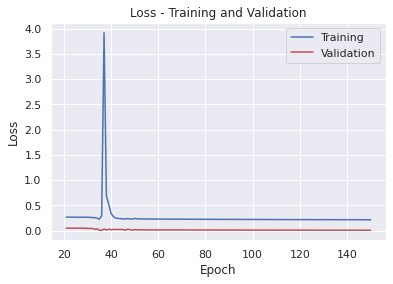

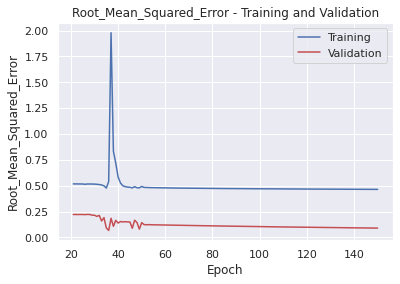

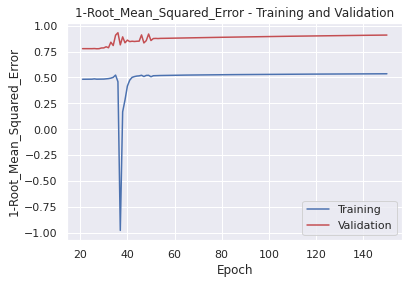

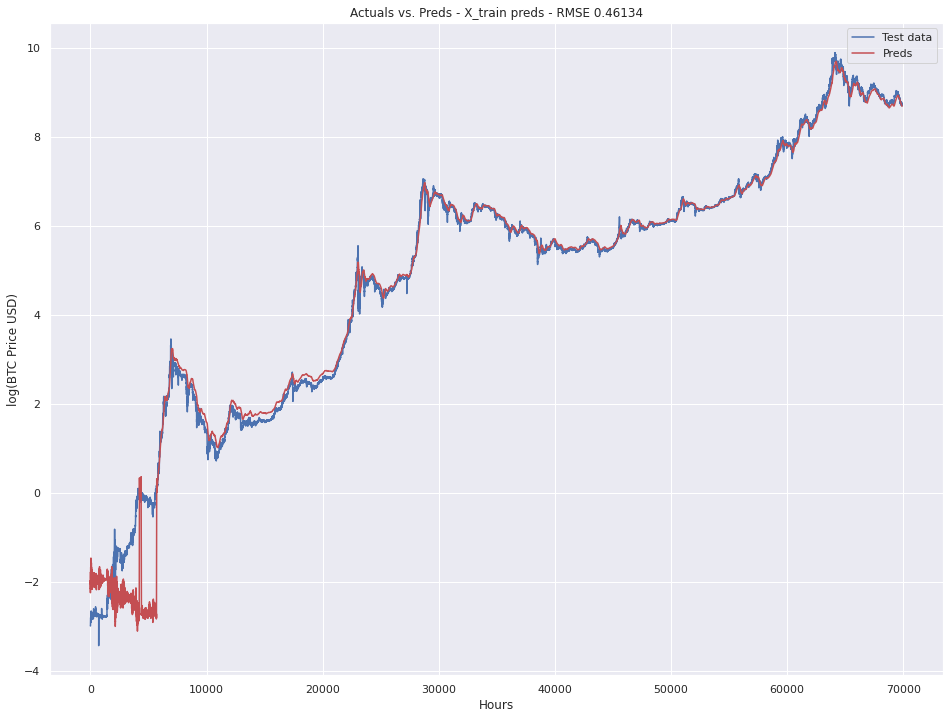

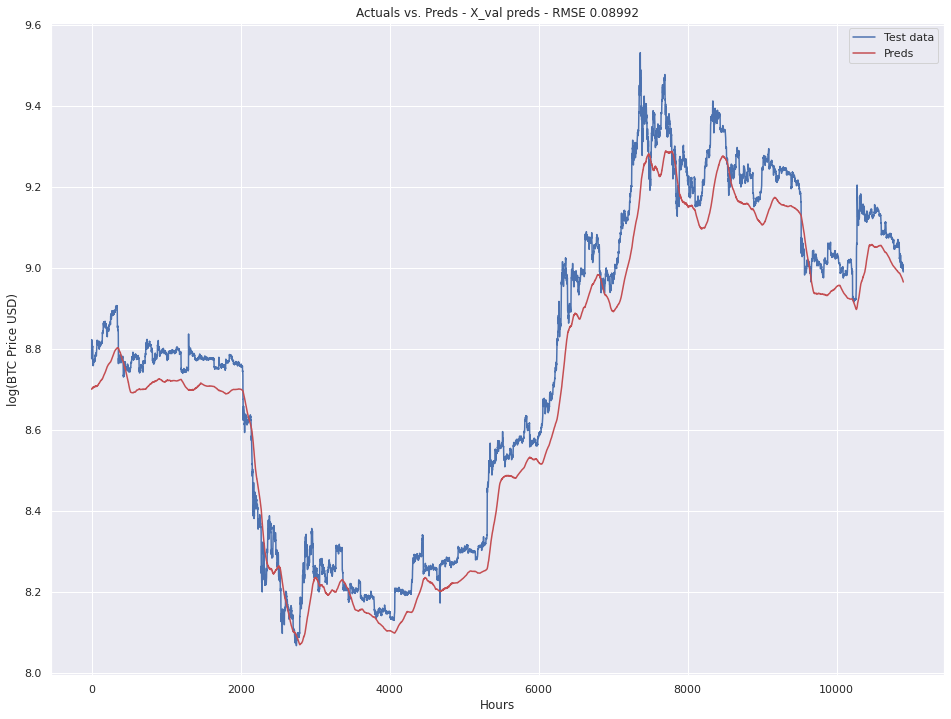

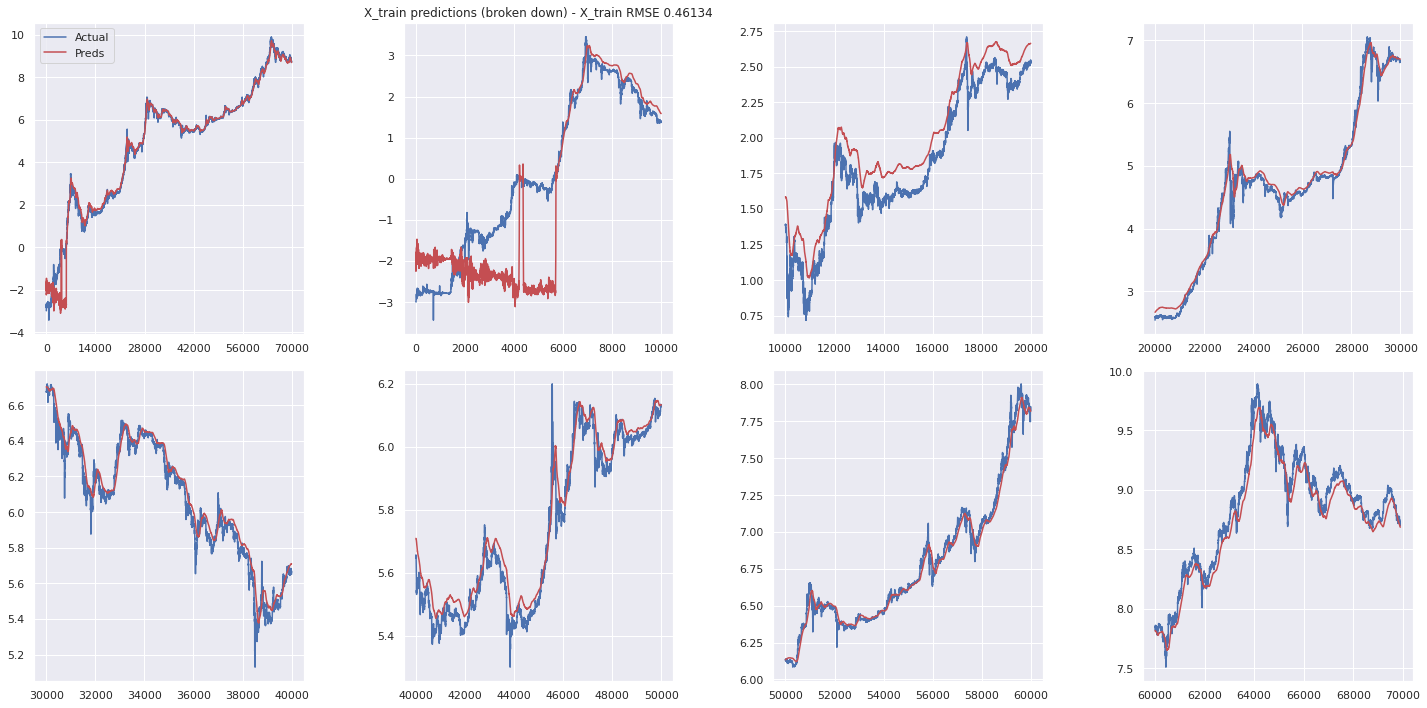

In [ ]:
# Initalize wandb with project name
run = wandb.init(project='bitcoin_price_predictor',
                 config={
                     'val_size': 0.12,
                     'test_size': 0.12,
                     'n_input': 168, # num lag observations
                     'n_nodes': 300, # num nodes per lauyer
                     'n_epochs': 150, # num training epochs
                     'n_batch': 168 * 20, # batch size
                     'num_layers': 3, # num layers used in MLP
                     'model_type': 'MLP',
                     'activation': 'relu',
                     'loss': 'mse',
                     # Model LR scheduler and optimizer
                     'use_lr_scheduler': True,
                     'lr_scheduler': 'InverseTimeDecay',
                     'initial_lr': 0.1,
                     'decay_steps': 1.0,
                     'decay_rate': 0.5,
                     'optimizer': 'adam',
                     # Other
                     'verbose': 2, # control verbosity of Keras fit
                     'dropna': True # whether to drop missing values from data
                         })
config = wandb.config # we use this to configure our experiment

history = main(config)

# Train, Val, Test Splits Visualized

(73754,) (9219,) (9219,)


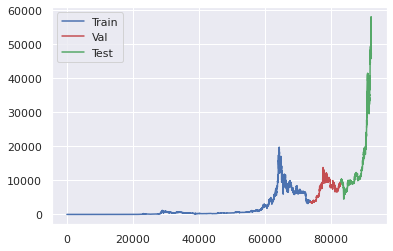

In [ ]:
n_val = int(len(data) * 0.10)
n_test = int(len(data) * 0.10)
tvt = train_val_test_split(data, n_val, n_test)
plot_train_val_test(*tvt)

WOAH THEY ARE SO DIFFERENT!

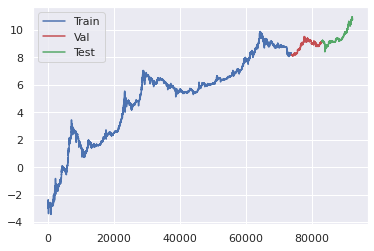

In [ ]:
log_tvt = scale_train_val_test(*tvt)
plot_train_val_test(*log_tvt)

# Load in saved model from wandb

In [ ]:
model_dir_str = '/content/drive/MyDrive/Work/Delivery/Current/bitcoin_price_predictor/models'
MODEL_DIR = Path(model_dir_str)
loaded_model = tf.keras.models.load_model(MODEL_DIR / 'model-best-cool-dragon-40.h5')

In [ ]:
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 300)               50700     
_________________________________________________________________
dense_9 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_10 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 301       
Total params: 231,601
Trainable params: 231,601
Non-trainable params: 0
_________________________________________________________________


# Plotting Training and Validation Curves

The ones on wandb are ok but I think it would be better to have them on the same plot (ideally plotly so that we can analyze them interactively).

In [ ]:
X_train, X_val, y_train, y_val = get_training_data()

In [ ]:
a = loaded_model.evaluate(X_train, y_train, verbose=0)
b = loaded_model.evaluate(X_val, y_val, verbose=0)
print(f'a loss: {a[0]}, a rmse: {a[1]}')
print(f'b loss: {b[0]}, b rmse: {b[1]}')

a loss: 0.028691021725535393, a rmse: 0.16938424110412598
b loss: 0.01623038947582245, b rmse: 0.1273985505104065


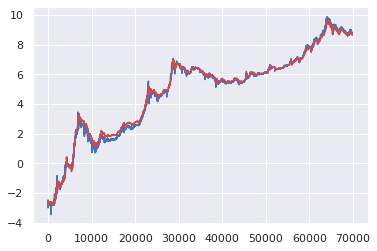

In [ ]:
plt.plot(y_train, 'b')
plt.plot(loaded_model.predict(X_train), 'r')
plt.show()

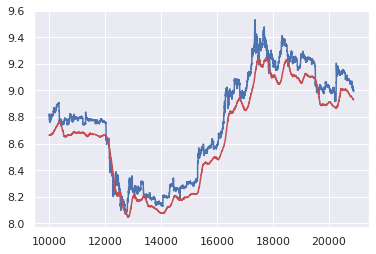

In [ ]:
plt.plot(y_val, 'b')
plt.plot(loaded_model.predict(X_val), 'r')
plt.xticks(ticks=np.arange(0, 12000, 2000),
           labels=np.arange(10000, 22000, 2000))
plt.show()

In [ ]:
len(y_train) // 10000

6

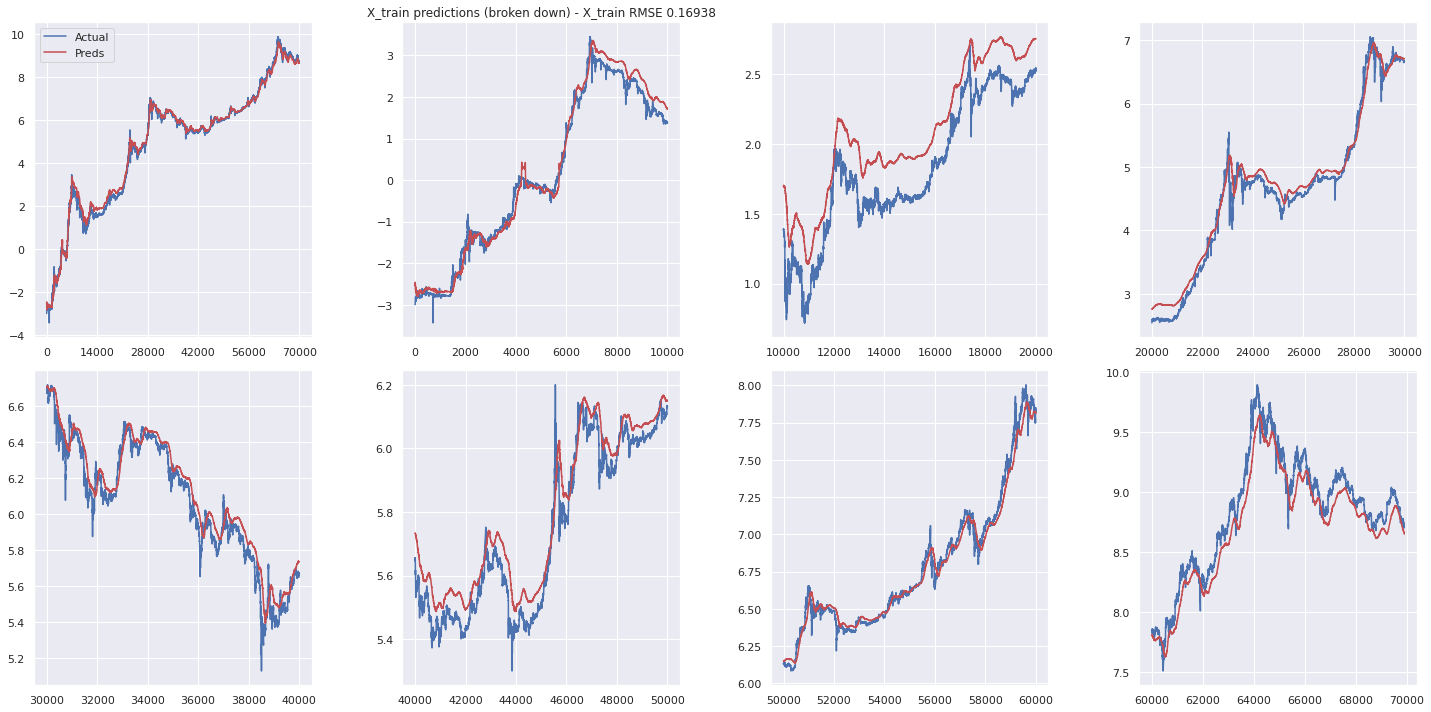

In [ ]:
def plot_preds_grid(y_true, y_pred, rmse):
    fig = plt.figure(figsize=(20, 10))
    # Plot full predictions
    plt.subplot(241)
    plt.plot(y_true, 'b', label='Actual')
    plt.plot(y_pred, 'r', label='Preds')
    plt.legend()
    plt.xticks(np.arange(0, 84000, 14000))
    # Plot predictions for each 10k hours
    for i in range(len(y_true) // 10000 + 1):
        plt.subplot(241+i+1)
        plt.plot(y_true[i * 10000: (i+1) * 10000], 'b')
        plt.plot(y_pred[i * 10000: (i+1) * 10000], 'r')
        plt.xticks(ticks=np.arange(0, 12000, 2000),
                   labels=np.arange(i * 10000, (i+1) * 10000 + 2000, 2000))
        if i == 0:
            title = f'X_train predictions (broken down) - X_train RMSE {rmse:.5f}'
            plt.title(title)
    plt.tight_layout()
    log_title = 'X_train predictions (broken down)'
    wandb.log({log_title: wandb.Image(fig)})
    plt.show()

y_pred = loaded_model.predict(X_train)
eval_results = loaded_model.evaluate(X_train, y_train, verbose=0)
rmse = eval_results[1]
plot_preds_grid(y_train, y_pred, rmse)

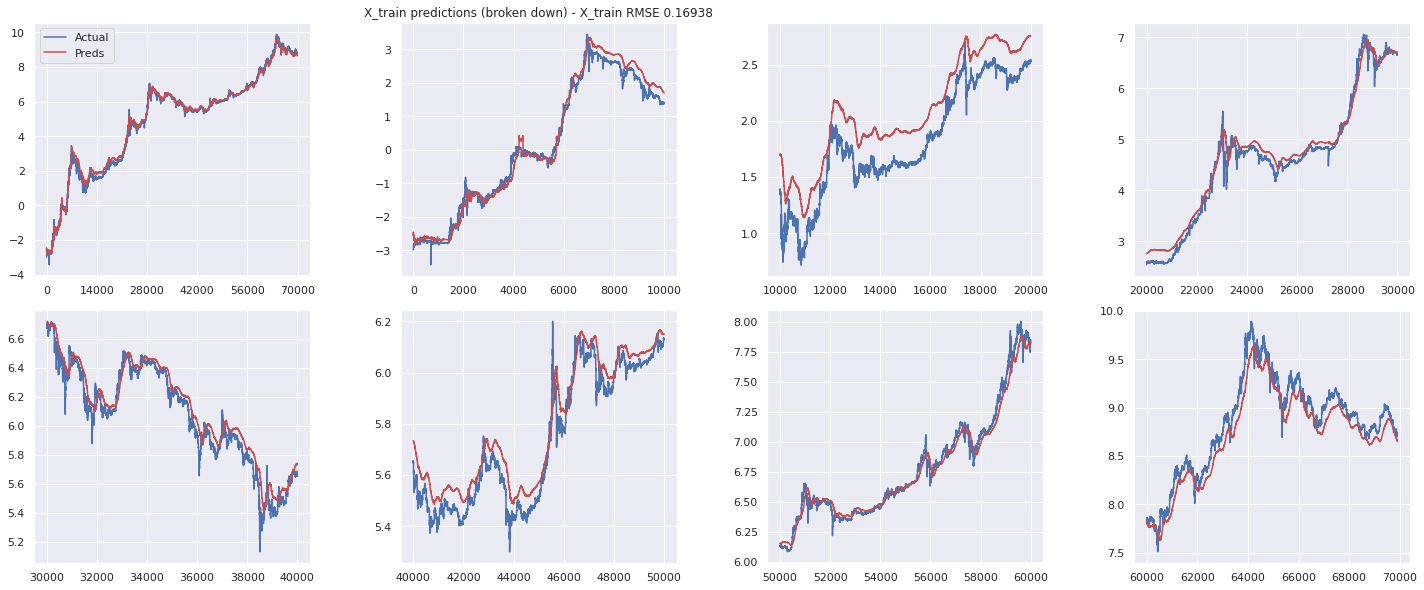

In [ ]:
def plot_X_train_preds_grid(model, X_train, y_train):
    plt.figure(figsize=(20, 16))
    # Plot full predictions
    plt.subplot(441)
    plt.plot(y_train, 'b', label='Actual')
    plt.plot(model.predict(X_train), 'r', label='Preds')
    plt.legend()
    plt.xticks(np.arange(0, 84000, 14000))
    # Plot predictions for each 10k hours
    for i in range(len(y_train) // 10000 + 1):
        plt.subplot(441+i+1)
        plt.plot(y_train[i * 10000: (i+1) * 10000], 'b')
        plt.plot(model.predict(X_train)[i * 10000: (i+1) * 10000], 'r')
        plt.xticks(ticks=np.arange(0, 12000, 2000),
                   labels=np.arange(i * 10000, (i+1) * 10000 + 2000, 2000))
        if i == 0:
            eval_results = model.evaluate(X_train, y_train, verbose=0)
            rmse = eval_results[1]
            title = f'X_train predictions (broken down) - X_train RMSE {rmse:.5f}'
            plt.title(title)
    plt.tight_layout()
    plt.show()


plot_X_train_preds_grid(loaded_model, X_train, y_train)

In [ ]:
70000 / 5

14000.0

In [ ]:
y_pred = loaded_model.predict(X_val)

In [ ]:
from helpers import _measure_rmse

_measure_rmse(y_val, y_pred)

0.027200741251082492

In [ ]:
from sklearn.metrics import mean_squared_error

np.exp(np.sqrt(mean_squared_error(y_val, y_pred)))

1.027574057427588

In [ ]:
X_val.shape, y_pred.shape, y_val.shape

((10895, 168), (10895, 1), (10895,))

In [ ]:
results = loaded_model.evaluate(X_val, y_val)

341/341 [==============================] - 0s 1ms/step - loss: 7.3988e-04


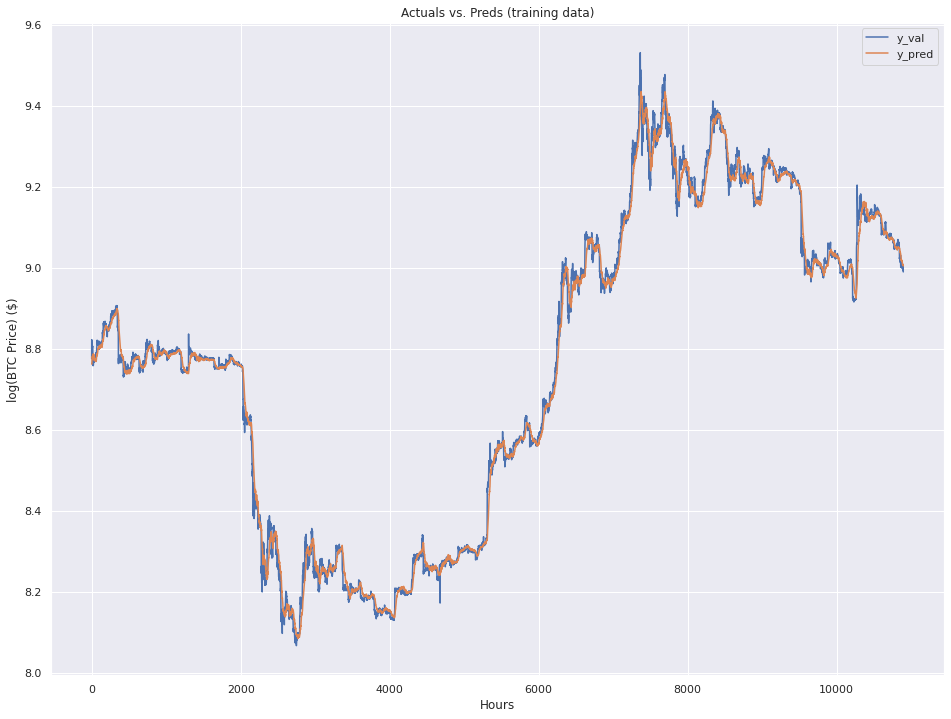

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(y_val, label='y_val')
ax.plot(y_pred, label='y_pred')
ax.legend()
ax.set(xlabel='Hours', ylabel='log(BTC Price) ($)', 
       title='Actuals vs. Preds (training data)')
plt.show()

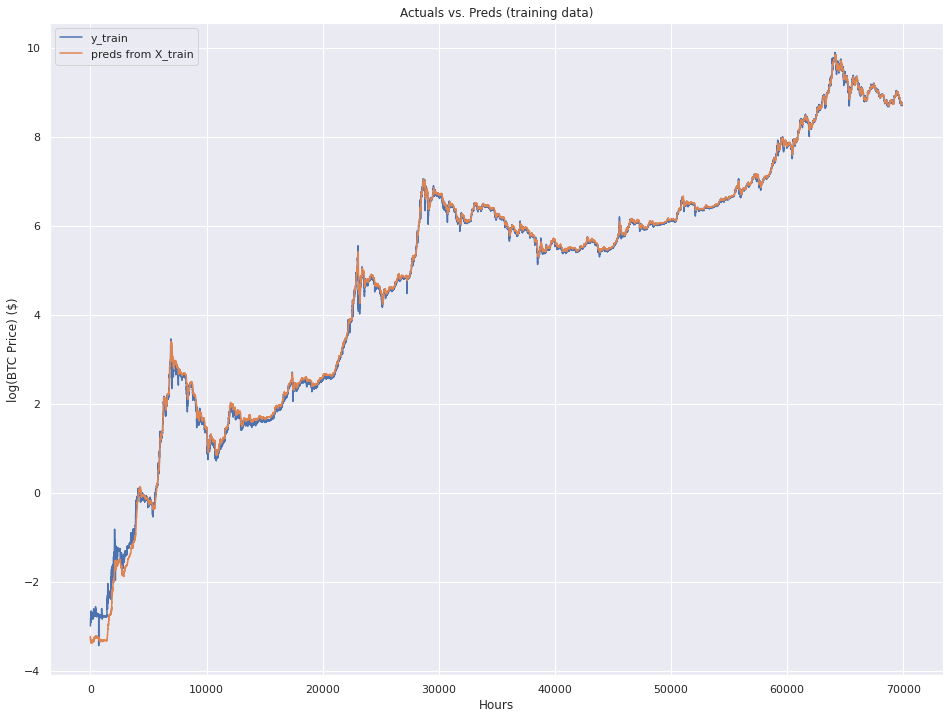

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(y_train, label='y_train')
ax.plot(loaded_model.predict(X_train), label='preds from X_train')
ax.legend()
ax.set(xlabel='Hours', ylabel='log(BTC Price) ($)', 
       title='Actuals vs. Preds (training data)')
plt.show()

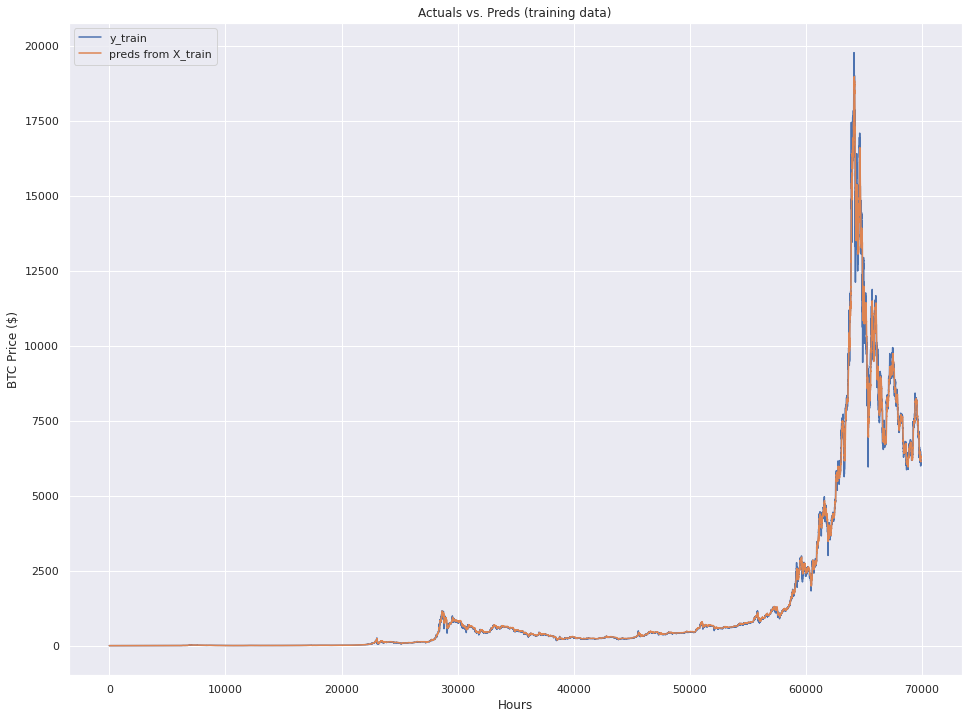

In [ ]:
# Not scaled
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(np.exp(y_train), label='y_train')
ax.plot(np.exp(loaded_model.predict(X_train)), label='preds from X_train')
ax.legend()
ax.set(xlabel='Hours', ylabel='BTC Price ($)', 
       title='Actuals vs. Preds (training data)')
plt.show()

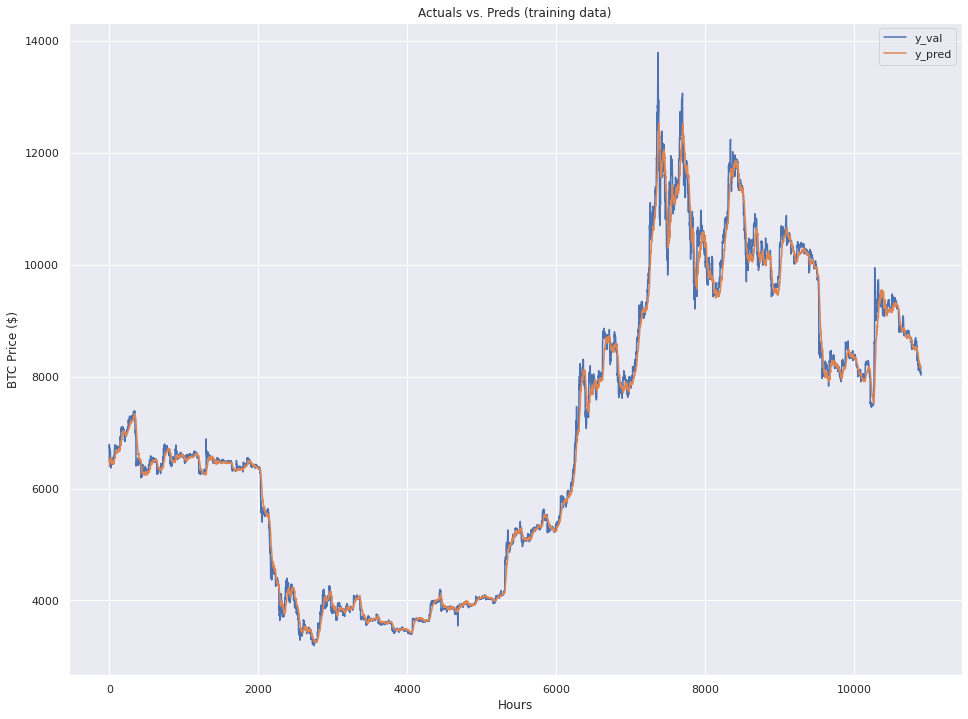

In [ ]:
# Not scaled val
fig, ax = plt.subplots(figsize=(16, 12))
ax.plot(np.exp(y_val), label='y_val')
ax.plot(np.exp(y_pred), label='y_pred')
ax.legend()
ax.set(xlabel='Hours', ylabel='BTC Price ($)', 
       title='Actuals vs. Preds (training data)')
plt.show()

# Creating Datasets 1 + 2

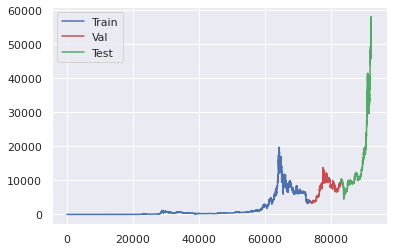

In [ ]:
n_val = int(len(data) * 0.10)
n_test = int(len(data) * 0.10)
train, val, test = train_val_test_split(data, n_val, n_test)
plot_train_val_test(train, val, test)

## Dataset 1

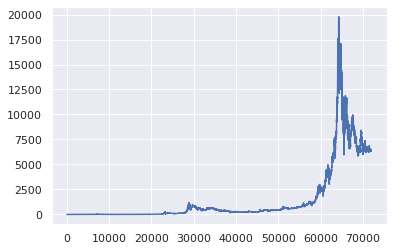

In [ ]:
dataset_1 = train[:72001]
plt.plot(dataset_1)

In [ ]:
with open(DATA_DIR / 'dataset_1.pkl', 'wb') as f:
    pickle.dump(dataset_1, f)

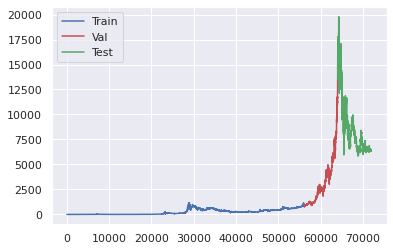

In [ ]:
n_val = int(len(dataset_1) * 0.11)
n_test = int(len(dataset_1) * 0.11)
train_1, val_1, test_1 = train_val_test_split(dataset_1, n_val, n_test)
plot_train_val_test(train_1, val_1, test_1)

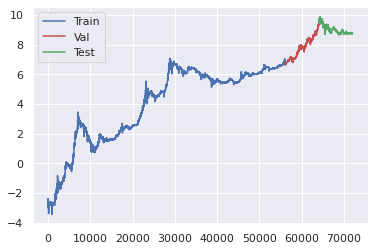

In [ ]:
n_val = int(len(dataset_1) * 0.11)
n_test = int(len(dataset_1) * 0.11)
train_1, val_1, test_1 = train_val_test_split(dataset_1, n_val, n_test)
plot_train_val_test(np.log(train_1), np.log(val_1), np.log(test_1))

In [ ]:
with open(DATA_DIR / 'train_1.pkl', 'wb') as f:
    pickle.dump(train_1, f)

with open(DATA_DIR / 'val_1.pkl', 'wb') as f:
    pickle.dump(val_1, f)

with open(DATA_DIR / 'test_1.pkl', 'wb') as f:
    pickle.dump(test_1, f)

## Dataset 2

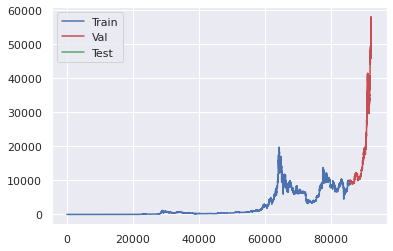

In [ ]:
n_val = int(len(data) * 0.07)
n_test = int(len(data) * 0.10)
train_2, val_2, test_2 = train_val_test_split(data, n_val, 1)
plot_train_val_test(train_2, val_2, test_2)

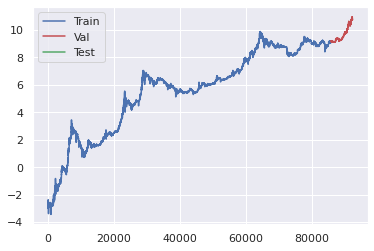

In [ ]:
n_val = int(len(data) * 0.07)
n_test = int(len(data) * 0.10)
train_2, val_2, test_2 = train_val_test_split(data, n_val, 1)
plot_train_val_test(np.log(train_2), np.log(val_2), np.log(test_2))

In [ ]:
with open(DATA_DIR / 'train_2.pkl', 'wb') as f:
    pickle.dump(train_2, f)

with open(DATA_DIR / 'val_2.pkl', 'wb') as f:
    pickle.dump(val_2, f)

In [ ]:
with open(DATA_DIR / 'dataset_2.pkl', 'wb') as f:
    pickle.dump(data, f)

# Model Training and Validation with Datasets 1 + 2

In [ ]:
def load_dataset_1():
    with open(DATA_DIR / 'train_1.pkl', 'rb') as f:
        train_1 = pickle.load(f)

    with open(DATA_DIR / 'val_1.pkl', 'rb') as f:
        val_1 = pickle.load(f)

    with open(DATA_DIR / 'test_1.pkl', 'rb') as f:
        test_1 = pickle.load(f)

    return train_1, val_1, test_1


def load_dataset_2():
    with open(DATA_DIR / 'train_2.pkl', 'rb') as f:
        train_2 = pickle.load(f)

    with open(DATA_DIR / 'val_2.pkl', 'rb') as f:
        val_2 = pickle.load(f)

    return train_2, val_2

In [ ]:
train_1, val_1, test_1 = load_dataset_1()
train_1, val_1 = scale_train_val_test(train_1, val_1, scaler='log')

In [ ]:
def train_and_validate(config, dataset=1):
    # Load in data
    if dataset == 1:
        train, val, _ = load_dataset_1()
    elif dataset == 2:
        train, val = load_dataset_2()
    else:
        raise Exception('Only two datasets are available: 1 or 2')
    # Scale data
    train, val = scale_train_val_test(train, val, scaler='log')
    # Get data into form Keras needs
    X_train, X_val, y_train, y_val = transform_to_keras_input(train,
                                                              val,
                                                              config.n_input)
    # Build and fit model
    model = build_model(config)
    history = fit_model(model, config, X_train, X_val, y_train, y_val)
    # Plot loss, rmse, and 1-rmse curves
    plot_metric(history, metric='loss', start_epoch=20)
    plot_metric(history, metric='root_mean_squared_error', start_epoch=20)
    plot_metric(history, metric='1-root_mean_squared_error', start_epoch=20)
    # Store history on wandb
    upload_history_to_wandb(history)

    # Calculate predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Calculate rmse for train and val data
    eval_results_train = model.evaluate(X_train, y_train, verbose=0)
    eval_results_val = model.evaluate(X_val, y_val, verbose=0)
    rmse_train = eval_results_train[1]
    rmse_val = eval_results_val[1]

    # Plot predictions for train and val data
    _plot_actual_vs_pred(y_train, y_pred_train, rmse=rmse_train,
                         name='X_train preds', logy=True)
    _plot_actual_vs_pred(y_val, y_pred_val, rmse=rmse_val,
                         name='X_val preds', logy=True)
    _plot_preds_grid(y_train, y_pred_train, rmse_train)
    return history

epoch,149
loss,0.08755
root_mean_squared_error,0.29588
val_loss,0.04686
val_root_mean_squared_error,0.21646
_runtime,31
_timestamp,1616755541
_step,156
best_val_loss,0.01154
best_epoch,11


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇█
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


Epoch 1/150
26/26 - 1s - loss: 25363398.0000 - root_mean_squared_error: 5036.2085 - val_loss: 3.4942 - val_root_mean_squared_error: 1.8693
Epoch 2/150
26/26 - 0s - loss: 5187.0000 - root_mean_squared_error: 72.0208 - val_loss: 191.4470 - val_root_mean_squared_error: 13.8364
Epoch 3/150
26/26 - 0s - loss: 111865.8203 - root_mean_squared_error: 334.4635 - val_loss: 830.5922 - val_root_mean_squared_error: 28.8200
Epoch 4/150
26/26 - 0s - loss: 3009.4714 - root_mean_squared_error: 54.8587 - val_loss: 54.0497 - val_root_mean_squared_error: 7.3518
Epoch 5/150
26/26 - 0s - loss: 211.7471 - root_mean_squared_error: 14.5515 - val_loss: 6.5754 - val_root_mean_squared_error: 2.5642
Epoch 6/150
26/26 - 0s - loss: 33.3940 - root_mean_squared_error: 5.7788 - val_loss: 5.0615 - val_root_mean_squared_error: 2.2498
Epoch 7/150
26/26 - 0s - loss: 3.4718 - root_mean_squared_error: 1.8633 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 8/150
26/26 - 0s - loss: 0.4359 - root_mean_squared_err

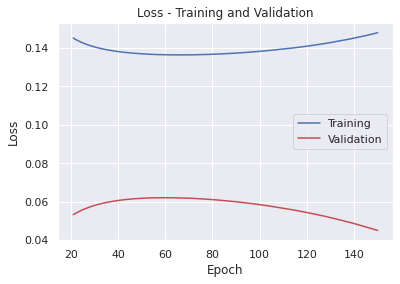

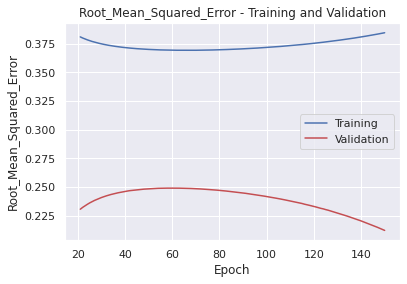

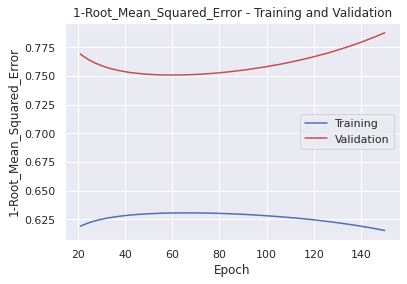

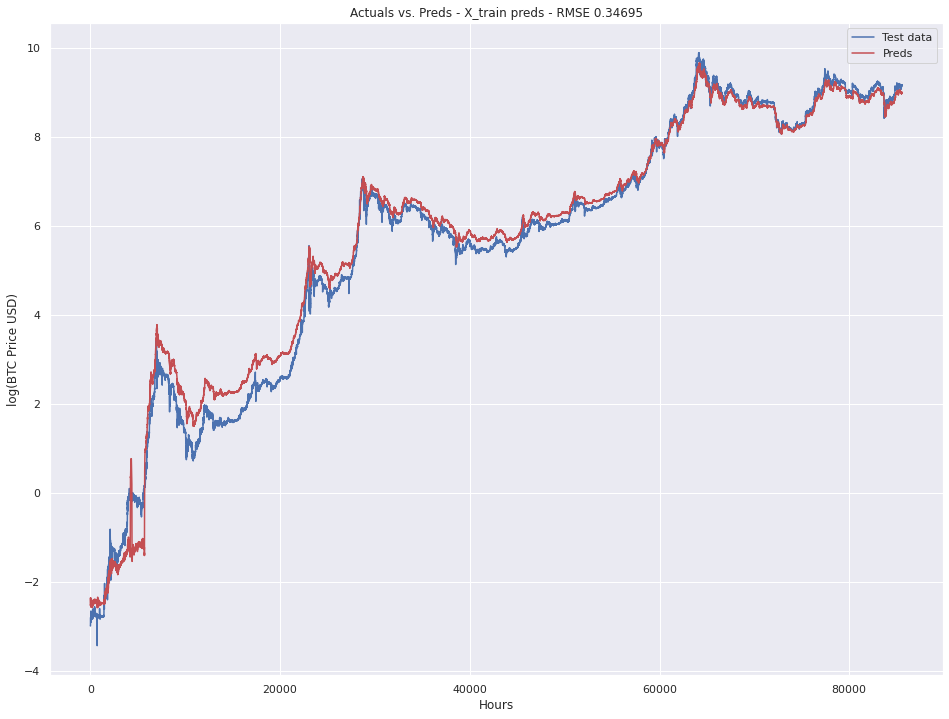

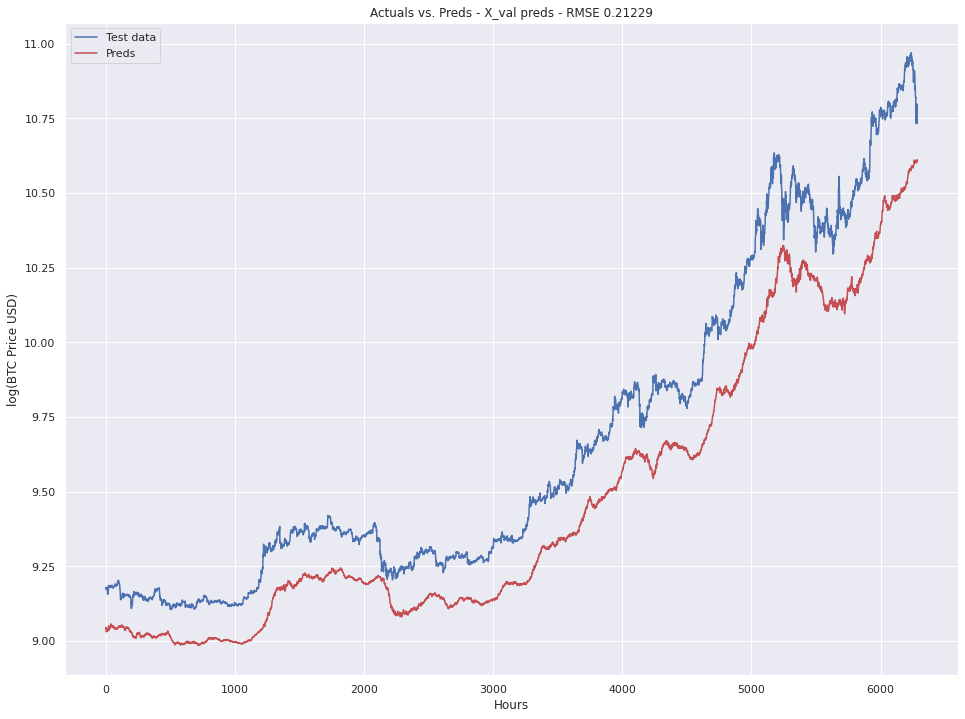

ValueError: ignored

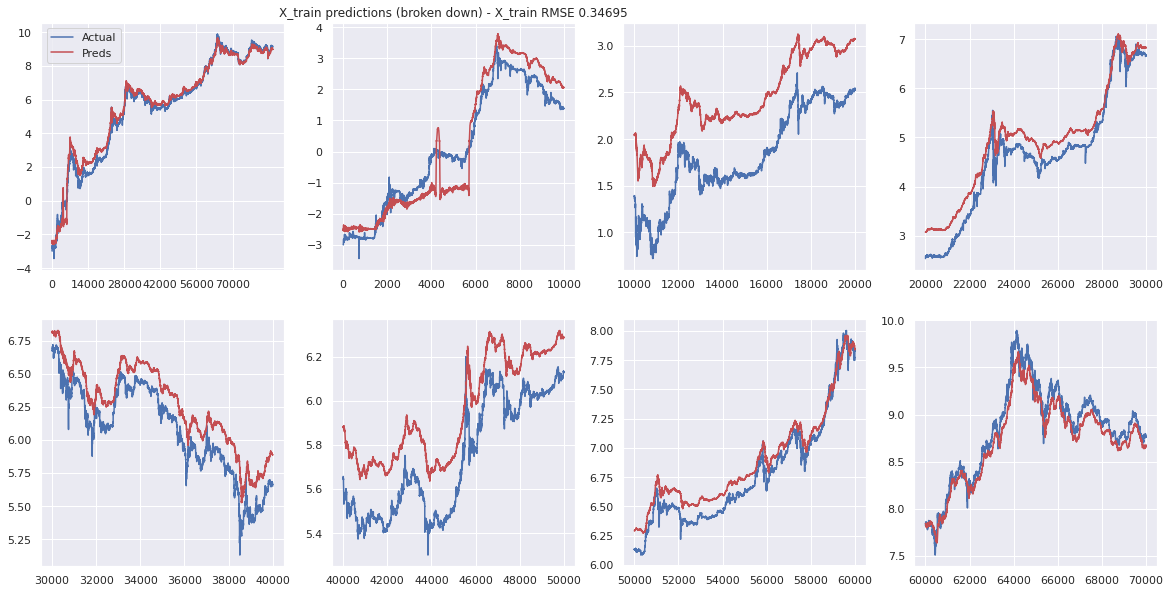

In [63]:
for i in range(5):
    # Initalize wandb with project name
    run = wandb.init(project='bitcoin_price_predictor',
                    config={
                        'dataset': 2,
                        'n_input': 168, # num lag observations
                        'n_nodes': 300, # num nodes per lauyer
                        'n_epochs': 150, # num training epochs
                        'n_batch': 168 * 20, # batch size
                        'num_layers': 3, # num layers used in MLP
                        'model_type': 'MLP',
                        'activation': 'relu',
                        'loss': 'mse',
                        # Model LR scheduler and optimizer
                        'use_lr_scheduler': True,
                        'lr_scheduler': 'InverseTimeDecay',
                        'initial_lr': 0.1,
                        'decay_steps': 1.0,
                        'decay_rate': 0.5,
                        'optimizer': 'adam',
                        # Other
                        'verbose': 2, # control verbosity of Keras fit
                        'dropna': True # whether to drop missing values from data
                            })
    config = wandb.config # we use this to configure our experiment

    history = train_and_validate(config, config.dataset)